Context: This Notebook is based on the Steel Plate Defect Prediction Competition (Playground Series - Season 4, Episode 3)((http://www.kaggle.com/competitions/playground-series-s4e3/overview)). In the competition, we are given synthetically-generated dataset based on the UCI's Steel Plates Faults datasset with the goal of predicting the probability of various defect on steel plate.

This notebook provides the various steps I have taken to develop the model.

#1. Importing the Dependencies
#2. Explorartory Data Analysis
#3. Data Preprocessing
#4. Hyperparameter Selection
#5. Ensemble and Submission

# #1.  Importing the Dependencies

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy.stats as stats
from sklearn.preprocessing import RobustScaler,StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split,StratifiedShuffleSplit
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, f1_score
import optuna

In [2]:
df_train=pd.read_csv(r'/kaggle/input/playground-series-s4e3/train.csv')
df_test=pd.read_csv(r'/kaggle/input/playground-series-s4e3/test.csv')
original_df=pd.read_csv(r'/kaggle/input/fault-steel-dataset-original/Fault_Steel_Original.csv')

In [3]:
id_test=df_test['id']

# 2. Explorartory Data Analysis

In [4]:
print(f"Shape of the Original Data: {original_df.shape}")

original_df.head().style.set_caption("Sample of the Original Data").\
set_properties(**{'border': '1.3px solid blue','color': 'grey'})

Shape of the Original Data: (1941, 35)


In [5]:
print(f"Shape of the Train Data: {df_train.shape}")

df_train.head().style.set_caption("Sample of data in the test data file"). \
set_properties(**{'border': '1.3px solid blue',
                          'color': 'grey'})



Shape of the Train Data: (19219, 35)


In [6]:
#check for missing values:
print("Missing Values: \n", df_train.isnull().sum())
print("Data Type: \n", df_train.info())

Missing Values: 
 id                       0
X_Minimum                0
X_Maximum                0
Y_Minimum                0
Y_Maximum                0
Pixels_Areas             0
X_Perimeter              0
Y_Perimeter              0
Sum_of_Luminosity        0
Minimum_of_Luminosity    0
Maximum_of_Luminosity    0
Length_of_Conveyer       0
TypeOfSteel_A300         0
TypeOfSteel_A400         0
Steel_Plate_Thickness    0
Edges_Index              0
Empty_Index              0
Square_Index             0
Outside_X_Index          0
Edges_X_Index            0
Edges_Y_Index            0
Outside_Global_Index     0
LogOfAreas               0
Log_X_Index              0
Log_Y_Index              0
Orientation_Index        0
Luminosity_Index         0
SigmoidOfAreas           0
Pastry                   0
Z_Scratch                0
K_Scatch                 0
Stains                   0
Dirtiness                0
Bumps                    0
Other_Faults             0
dtype: int64
<class 'pandas.core.fram

Key takeaways: There is no missing data in the training dataset. There are only int and float. There are no categorical variable

In [7]:
#check for missing values in the original data:
print("Missing Values: \n", original_df.isnull().sum())
print("Data Type: \n", original_df.info())

Missing Values: 
 id                       0
X_Minimum                0
X_Maximum                0
Y_Minimum                0
Y_Maximum                0
Pixels_Areas             0
X_Perimeter              0
Y_Perimeter              0
Sum_of_Luminosity        0
Minimum_of_Luminosity    0
Maximum_of_Luminosity    0
Length_of_Conveyer       0
TypeOfSteel_A300         0
TypeOfSteel_A400         0
Steel_Plate_Thickness    0
Edges_Index              0
Empty_Index              0
Square_Index             0
Outside_X_Index          0
Edges_X_Index            0
Edges_Y_Index            0
Outside_Global_Index     0
LogOfAreas               0
Log_X_Index              0
Log_Y_Index              0
Orientation_Index        0
Luminosity_Index         0
SigmoidOfAreas           0
Pastry                   0
Z_Scratch                0
K_Scatch                 0
Stains                   0
Dirtiness                0
Bumps                    0
Other_Faults             0
dtype: int64
<class 'pandas.core.fram

In [8]:
#lets concatenate the two data
df_train_final=pd.concat([original_df,df_train], ignore_index=True)
df_train_final.head().style.set_caption("Sample of the Final Data").\
set_properties(**{'border': '1.3px solid blue','color': 'grey'})

In [9]:
print(f"Shape of the Test Data: {df_test.shape}")

df_test.head().style.set_caption("Sample of data in the test data file"). \
set_properties(**{'border': '1.3px solid blue',
                          'color': 'grey'})



Shape of the Test Data: (12814, 28)


In [10]:
print("Missing Values: \n", df_test.isnull().sum())
print("Data Type: \n", df_test.info())

Missing Values: 
 id                       0
X_Minimum                0
X_Maximum                0
Y_Minimum                0
Y_Maximum                0
Pixels_Areas             0
X_Perimeter              0
Y_Perimeter              0
Sum_of_Luminosity        0
Minimum_of_Luminosity    0
Maximum_of_Luminosity    0
Length_of_Conveyer       0
TypeOfSteel_A300         0
TypeOfSteel_A400         0
Steel_Plate_Thickness    0
Edges_Index              0
Empty_Index              0
Square_Index             0
Outside_X_Index          0
Edges_X_Index            0
Edges_Y_Index            0
Outside_Global_Index     0
LogOfAreas               0
Log_X_Index              0
Log_Y_Index              0
Orientation_Index        0
Luminosity_Index         0
SigmoidOfAreas           0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12814 entries, 0 to 12813
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  


#Lets look at how does the distribution of features in test and training data looks like

In [11]:
#drop id column from the test and train data
df_test=df_test.drop(columns="id")
df_train_final=df_train_final.drop(columns="id")

In [12]:
df_train_final.columns.to_list()

['X_Minimum',
 'X_Maximum',
 'Y_Minimum',
 'Y_Maximum',
 'Pixels_Areas',
 'X_Perimeter',
 'Y_Perimeter',
 'Sum_of_Luminosity',
 'Minimum_of_Luminosity',
 'Maximum_of_Luminosity',
 'Length_of_Conveyer',
 'TypeOfSteel_A300',
 'TypeOfSteel_A400',
 'Steel_Plate_Thickness',
 'Edges_Index',
 'Empty_Index',
 'Square_Index',
 'Outside_X_Index',
 'Edges_X_Index',
 'Edges_Y_Index',
 'Outside_Global_Index',
 'LogOfAreas',
 'Log_X_Index',
 'Log_Y_Index',
 'Orientation_Index',
 'Luminosity_Index',
 'SigmoidOfAreas',
 'Pastry',
 'Z_Scratch',
 'K_Scatch',
 'Stains',
 'Dirtiness',
 'Bumps',
 'Other_Faults']

In [13]:
unique_col=pd.DataFrame(columns=["cols","Unique_Counts"])
unique_col_list = [df_train_final[c].nunique() for c in df_train_final.columns]
unique_col["cols"] = df_train_final.columns.to_list()
unique_col["Unique_Counts"] = unique_col_list
unique_col.head(26)

cols  Unique_Counts
0               X_Minimum           1218
1               X_Maximum           1272
2               Y_Minimum           3463
3               Y_Maximum           3450
4            Pixels_Areas           1160
5             X_Perimeter            471
6             Y_Perimeter            338
7       Sum_of_Luminosity           2619
8   Minimum_of_Luminosity            165
9   Maximum_of_Luminosity            104
10     Length_of_Conveyer            100
11       TypeOfSteel_A300              2
12       TypeOfSteel_A400              2
13  Steel_Plate_Thickness             27
14            Edges_Index           1876
15            Empty_Index           1773
16           Square_Index           1137
17        Outside_X_Index            531
18          Edges_X_Index           1116
19          Edges_Y_Index            912
20   Outside_Global_Index              4
21             LogOfAreas           1083
22            Log_X_Index            210
23            Log_Y_Index            245
24      Orientation_Index           1634
25       Luminosity_Index           2069

In [14]:
target=df_train_final.columns.to_list()[-7:]

In [15]:
df_train_final['TypeOfSteel_A400'] = pd.Categorical(df_train_final.TypeOfSteel_A400)
df_train_final['TypeOfSteel_A300'] = pd.Categorical(df_train_final.TypeOfSteel_A300)

df_train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21160 entries, 0 to 21159
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   X_Minimum              21160 non-null  int64   
 1   X_Maximum              21160 non-null  int64   
 2   Y_Minimum              21160 non-null  int64   
 3   Y_Maximum              21160 non-null  int64   
 4   Pixels_Areas           21160 non-null  int64   
 5   X_Perimeter            21160 non-null  int64   
 6   Y_Perimeter            21160 non-null  int64   
 7   Sum_of_Luminosity      21160 non-null  int64   
 8   Minimum_of_Luminosity  21160 non-null  int64   
 9   Maximum_of_Luminosity  21160 non-null  int64   
 10  Length_of_Conveyer     21160 non-null  int64   
 11  TypeOfSteel_A300       21160 non-null  category
 12  TypeOfSteel_A400       21160 non-null  category
 13  Steel_Plate_Thickness  21160 non-null  int64   
 14  Edges_Index            21160 non-null 

In [16]:
df_numerical=df_train_final.select_dtypes(include=np.number).columns
df_categorical= df_train_final.select_dtypes(include='category').columns
df_numerical=[c for c in df_numerical if c not in target]
print(f"Numerical Columns : {df_numerical}")
print(f"\n Categorical Columns : {df_categorical}")

Numerical Columns : ['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer', 'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas']

 Categorical Columns : Index(['TypeOfSteel_A300', 'TypeOfSteel_A400'], dtype='object')


In [17]:
def plot_histogram(train, test,n_cols):
    columns= train.columns.to_list()
    columns = [c for c in columns if c in df_numerical]
    n_rows = (len(columns) - 1) // n_cols + 1
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(21, 4 * n_rows))
    axs = axs.flatten()
    train["type"]="Train"
    test["type"]= "Test"
    train_test=pd.concat([train,test], ignore_index=True)
    for i, column in enumerate(columns):
        sns.histplot(data=train_test,x=column, hue="type", multiple="dodge", ax=axs[i], kde=True)        
        axs[i].set_title(f'{column} Plot', fontsize=18)
        axs[i].set_xlabel(column, fontsize=16)
        axs[i].set_ylabel(None, fontsize=16)
        axs[i].tick_params(axis='x', rotation=90)
    plt.tight_layout()
    plt.show()

Key Takeaways: The distribution in the variables in the test and train data is very similar. 
Followimg variables are highly skewed : Y_Maximum ,Y_Minimum, Pixel_Areas, X_Perimeter, Y_Perimeter, Sum_luminosity_plot

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

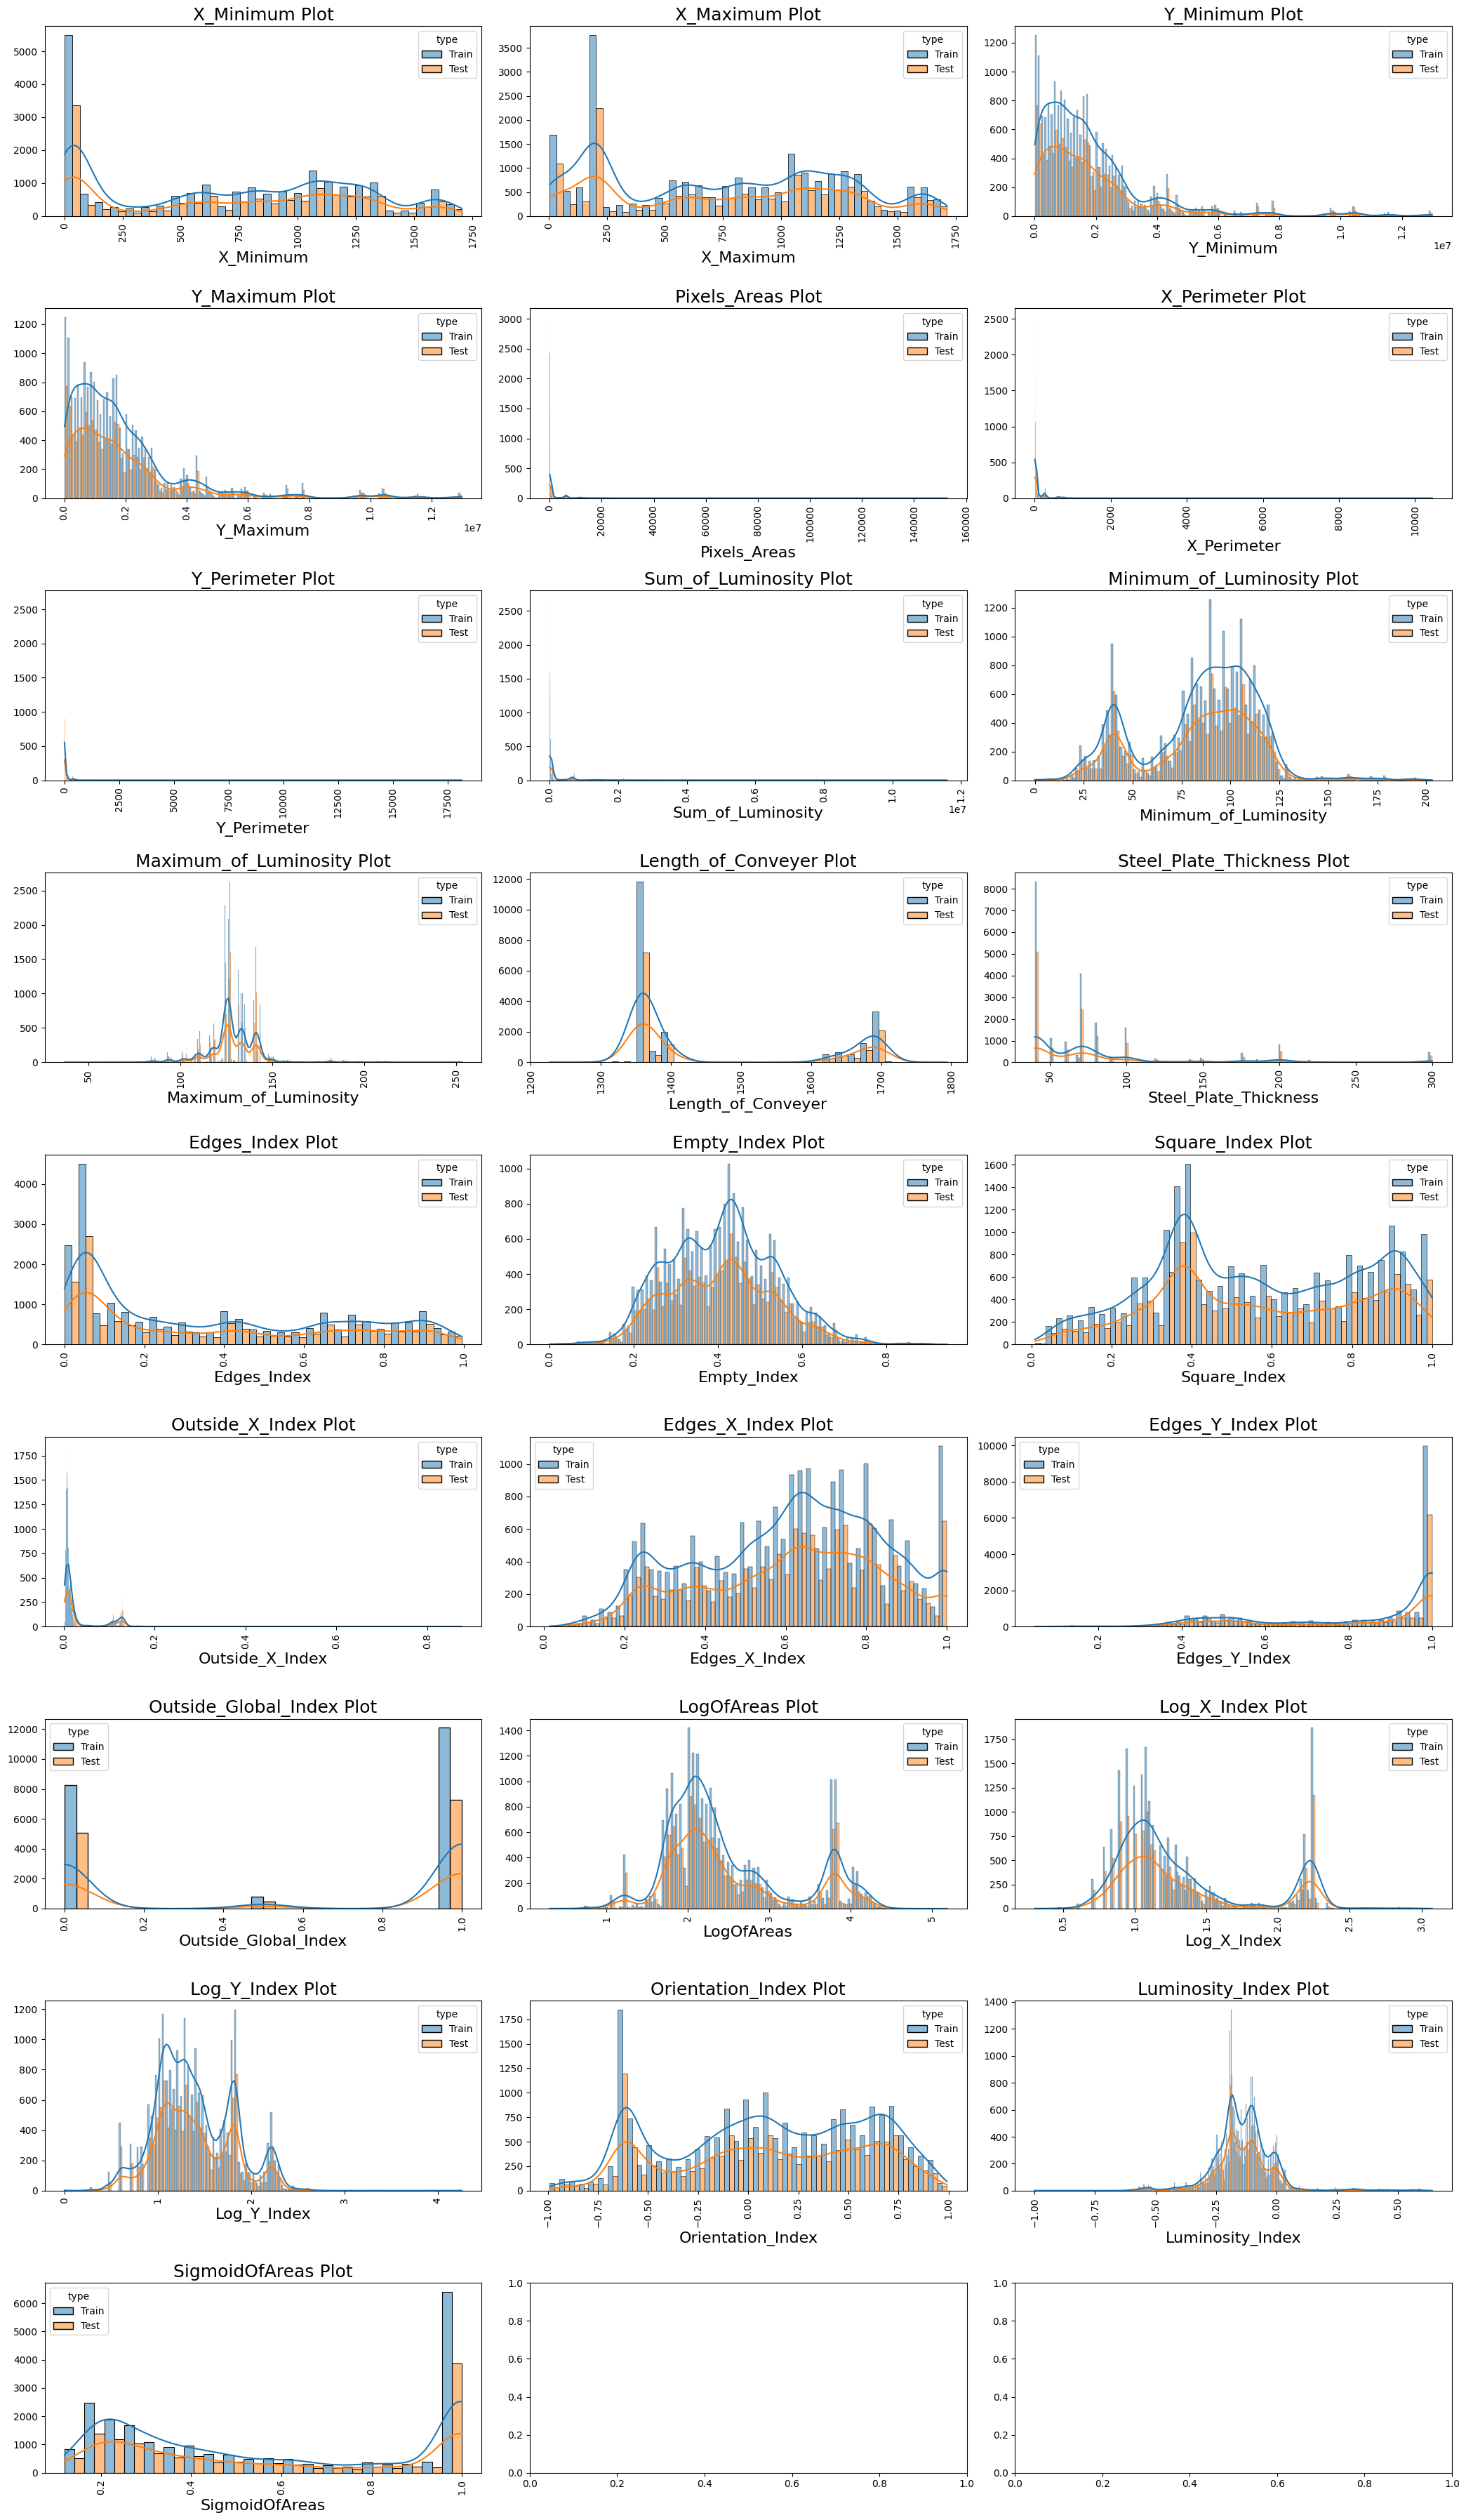

In [18]:
plot_histogram(df_train_final.drop(columns=target), df_test,3)

Perform the analysis on the target variable to see the concentration across different defect types

In [19]:
target_distribution= df_train_final[target].sum().to_frame()
#target_distribution=target_distribution.reset_index(drop=False)
target_distribution.columns=['Count']
target_distribution

Count
Pastry         1624
Z_Scratch      1340
K_Scatch       3823
Stains          640
Dirtiness       540
Bumps          5165
Other_Faults   7231

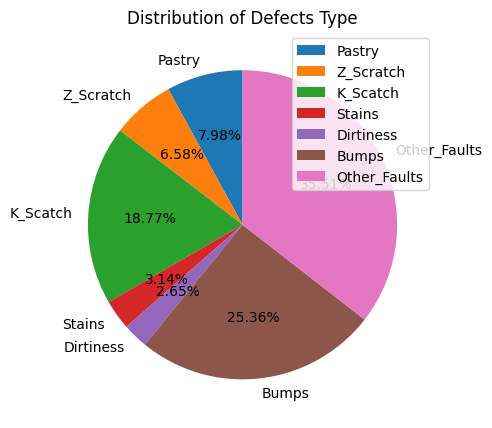

In [20]:
fig,ax=plt.subplots(figsize=(5,5))
ax.set_title("Distribution of Defects Type")
target_distribution.plot.pie(y='Count', legend=True, autopct='%1.2f%%', ax=ax,startangle=90)
plt.ylabel("")
plt.tight_layout()
plt.show()

In [21]:
features= [c for c in df_train_final.columns.to_list() if c not in target and c not in df_categorical]
features

['X_Minimum',
 'X_Maximum',
 'Y_Minimum',
 'Y_Maximum',
 'Pixels_Areas',
 'X_Perimeter',
 'Y_Perimeter',
 'Sum_of_Luminosity',
 'Minimum_of_Luminosity',
 'Maximum_of_Luminosity',
 'Length_of_Conveyer',
 'Steel_Plate_Thickness',
 'Edges_Index',
 'Empty_Index',
 'Square_Index',
 'Outside_X_Index',
 'Edges_X_Index',
 'Edges_Y_Index',
 'Outside_Global_Index',
 'LogOfAreas',
 'Log_X_Index',
 'Log_Y_Index',
 'Orientation_Index',
 'Luminosity_Index',
 'SigmoidOfAreas']

In [22]:
def plot_corr(df, features):
    for t in target:
        cols= features + [t]
        fig,ax=plt.subplots(figsize=(15,10))
        matrix = df[cols].corr().round(2)
        mask = np.triu(np.ones_like(matrix, dtype=bool))
        sns.heatmap(matrix, annot=True, ax=ax, mask=mask)
        plt.title(f"HeatMap with respect to {t}")
        plt.tight_layout()
        plt.show()

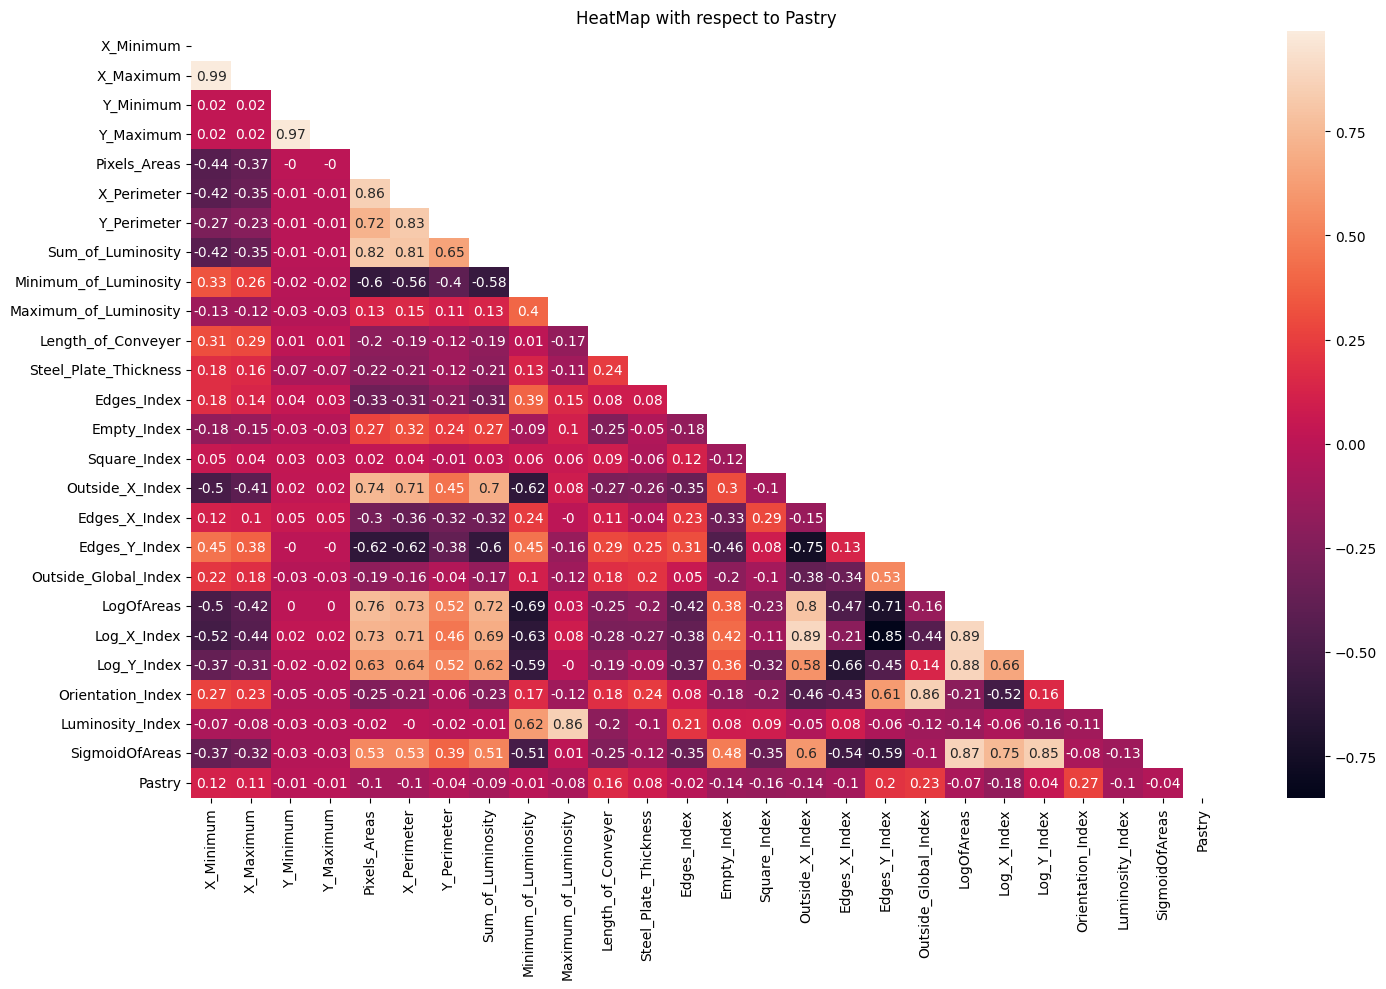

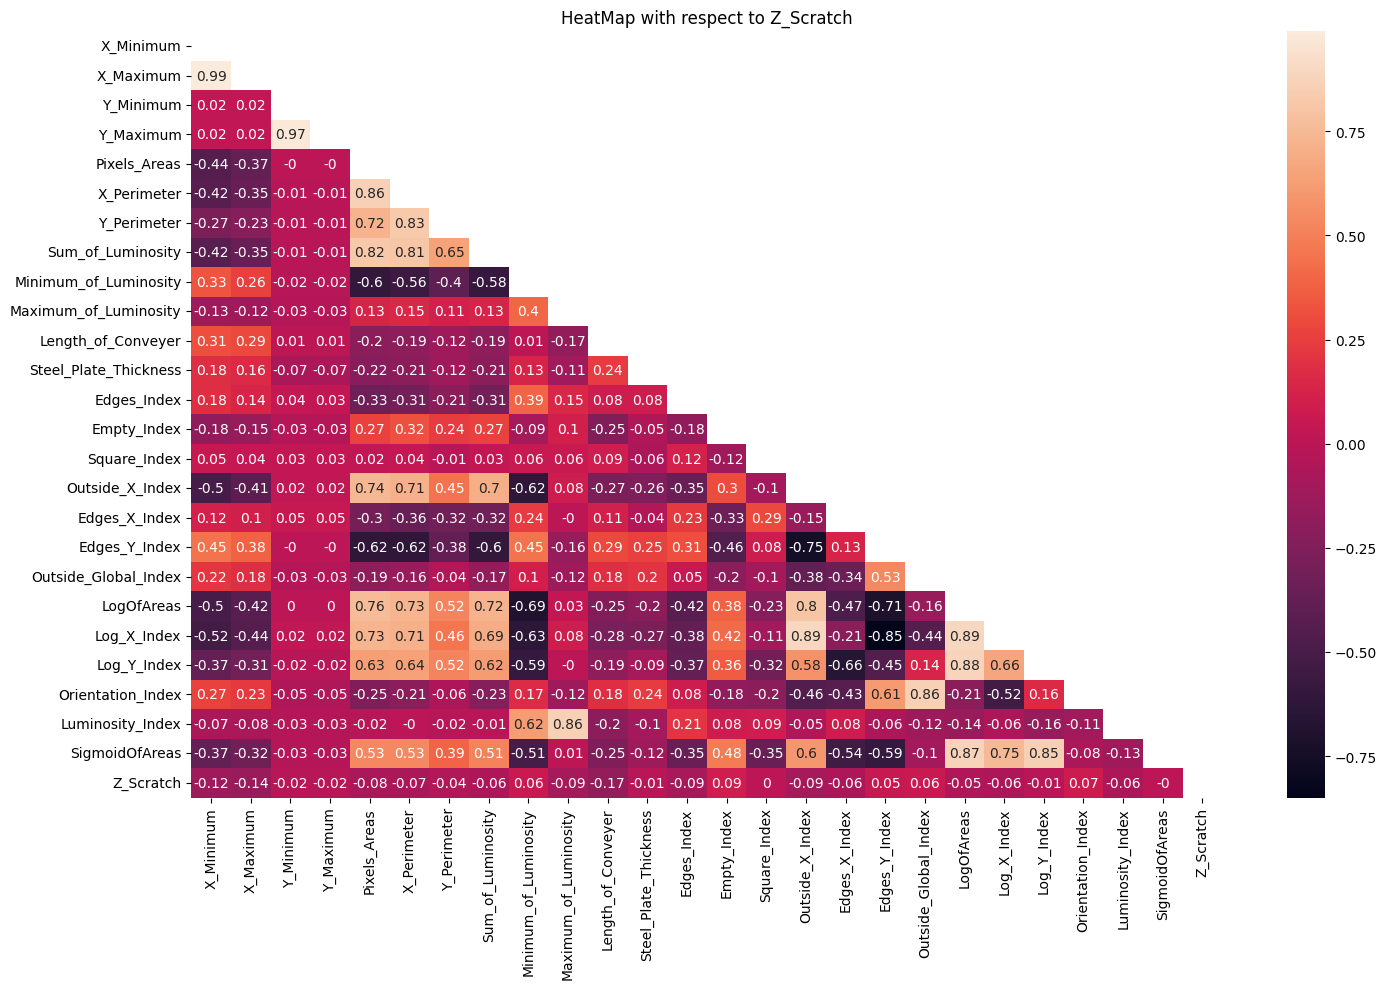

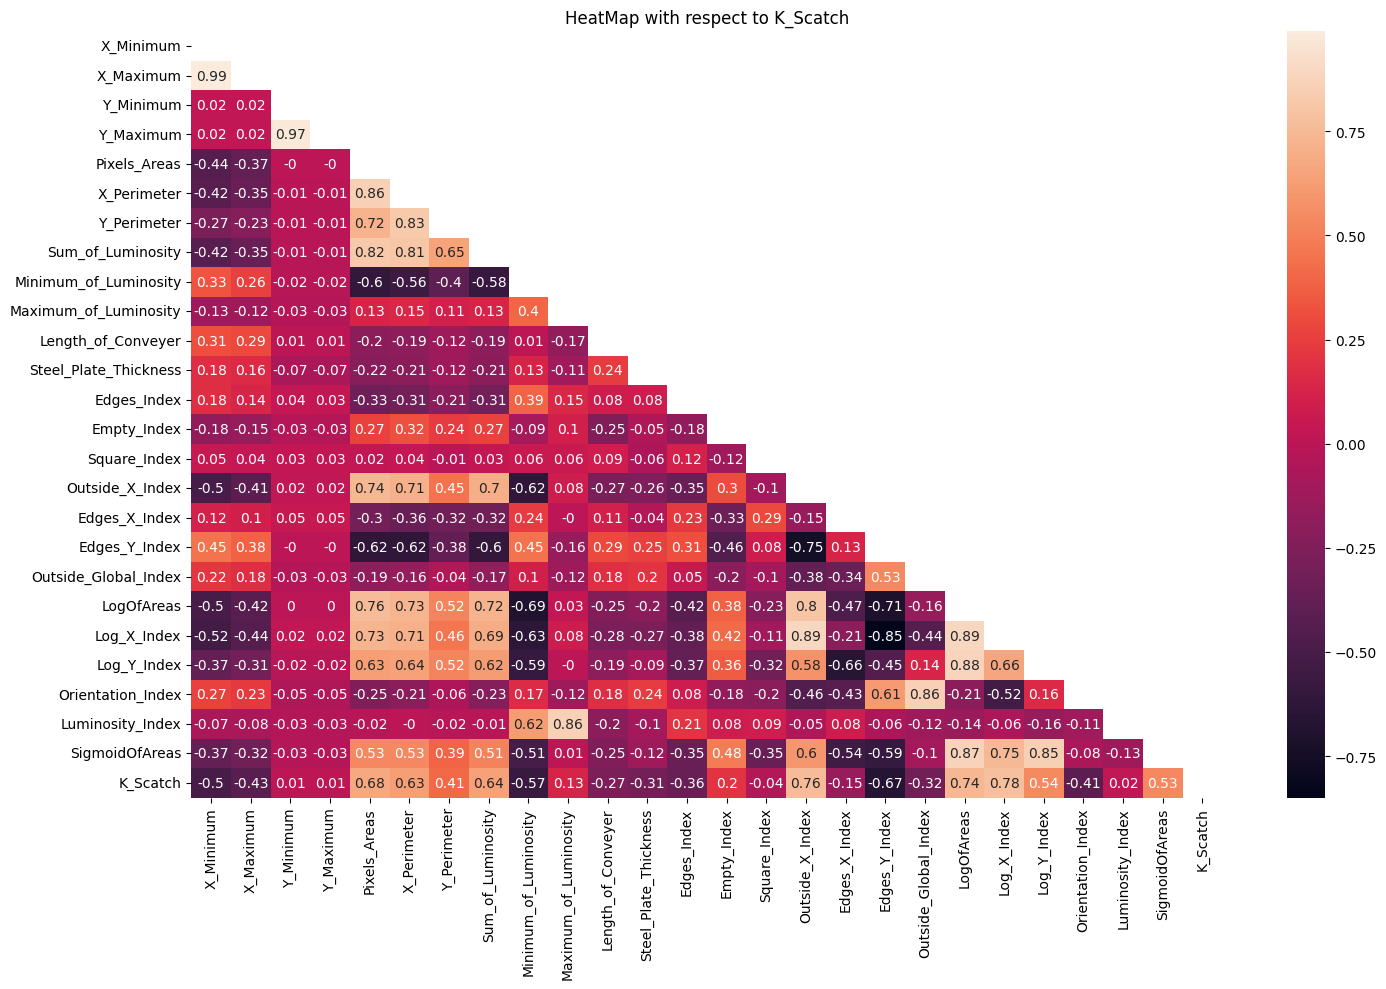

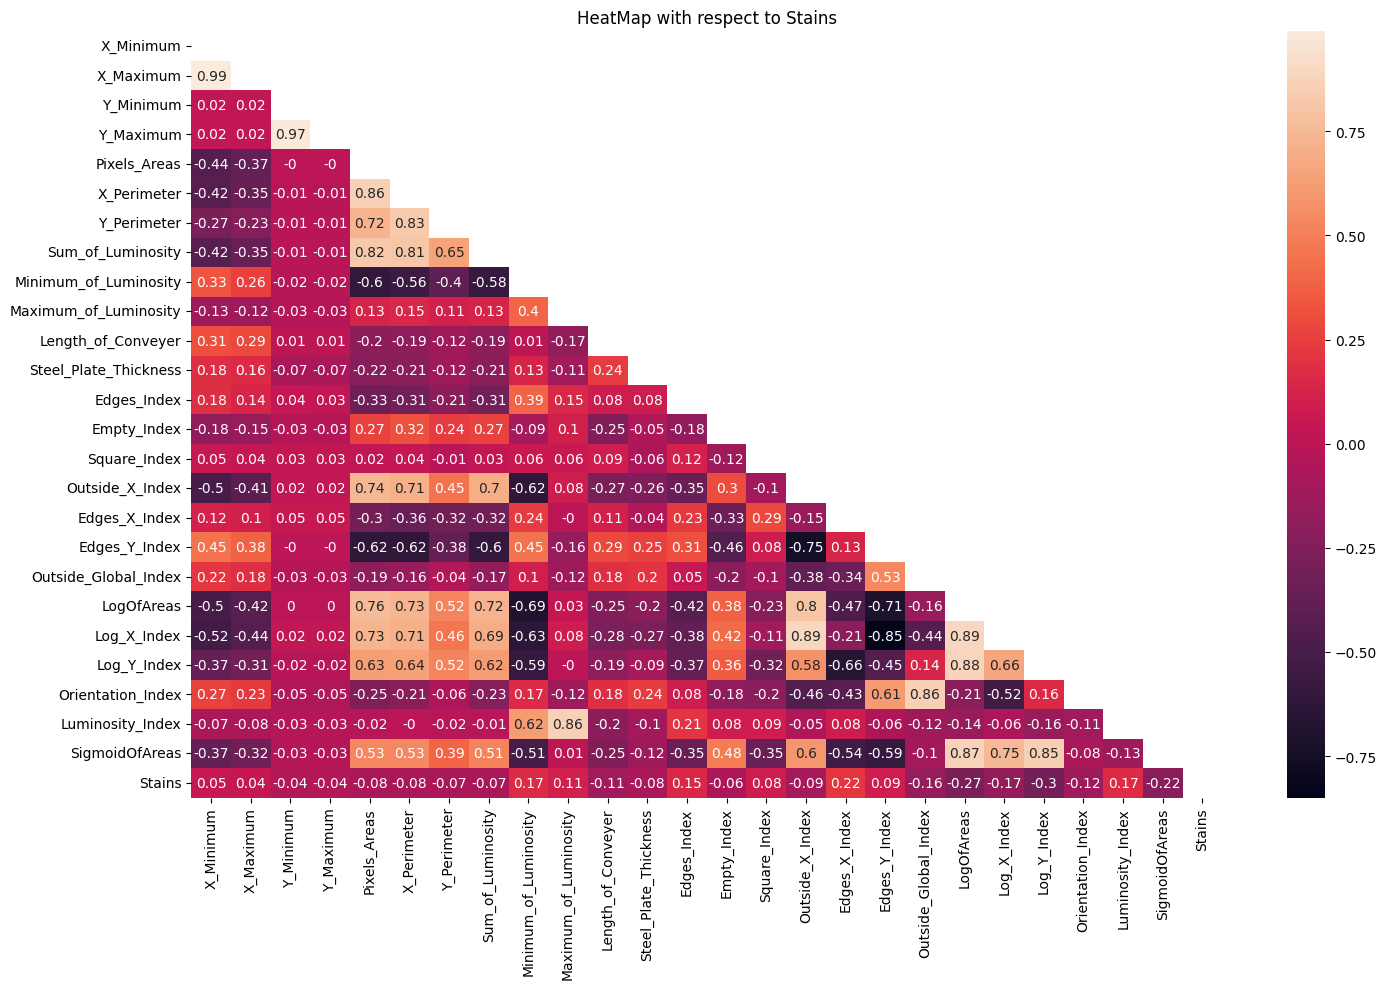

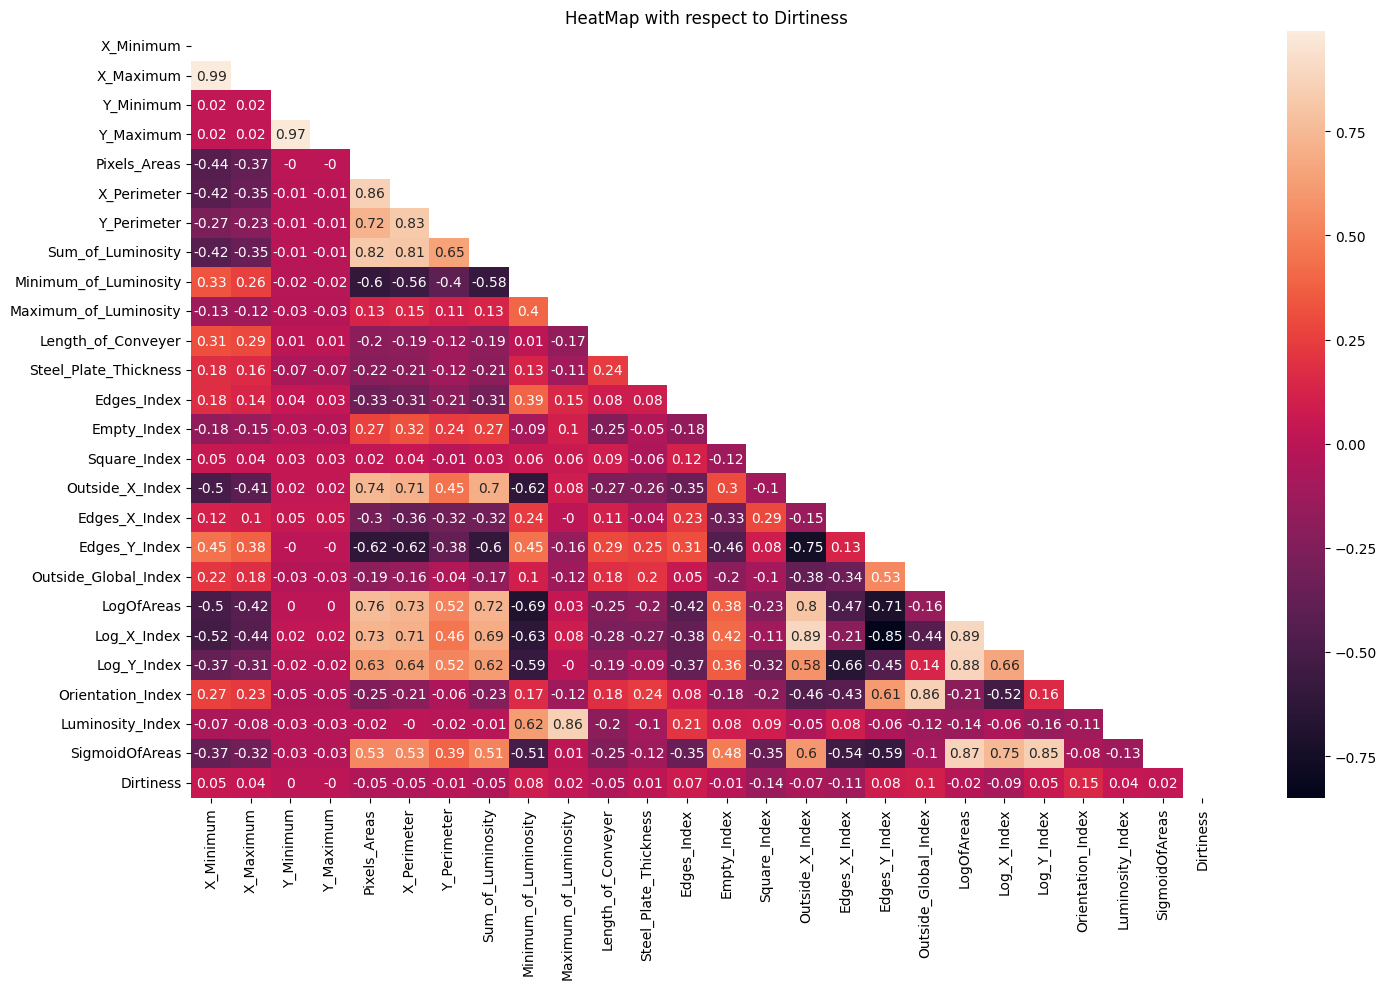

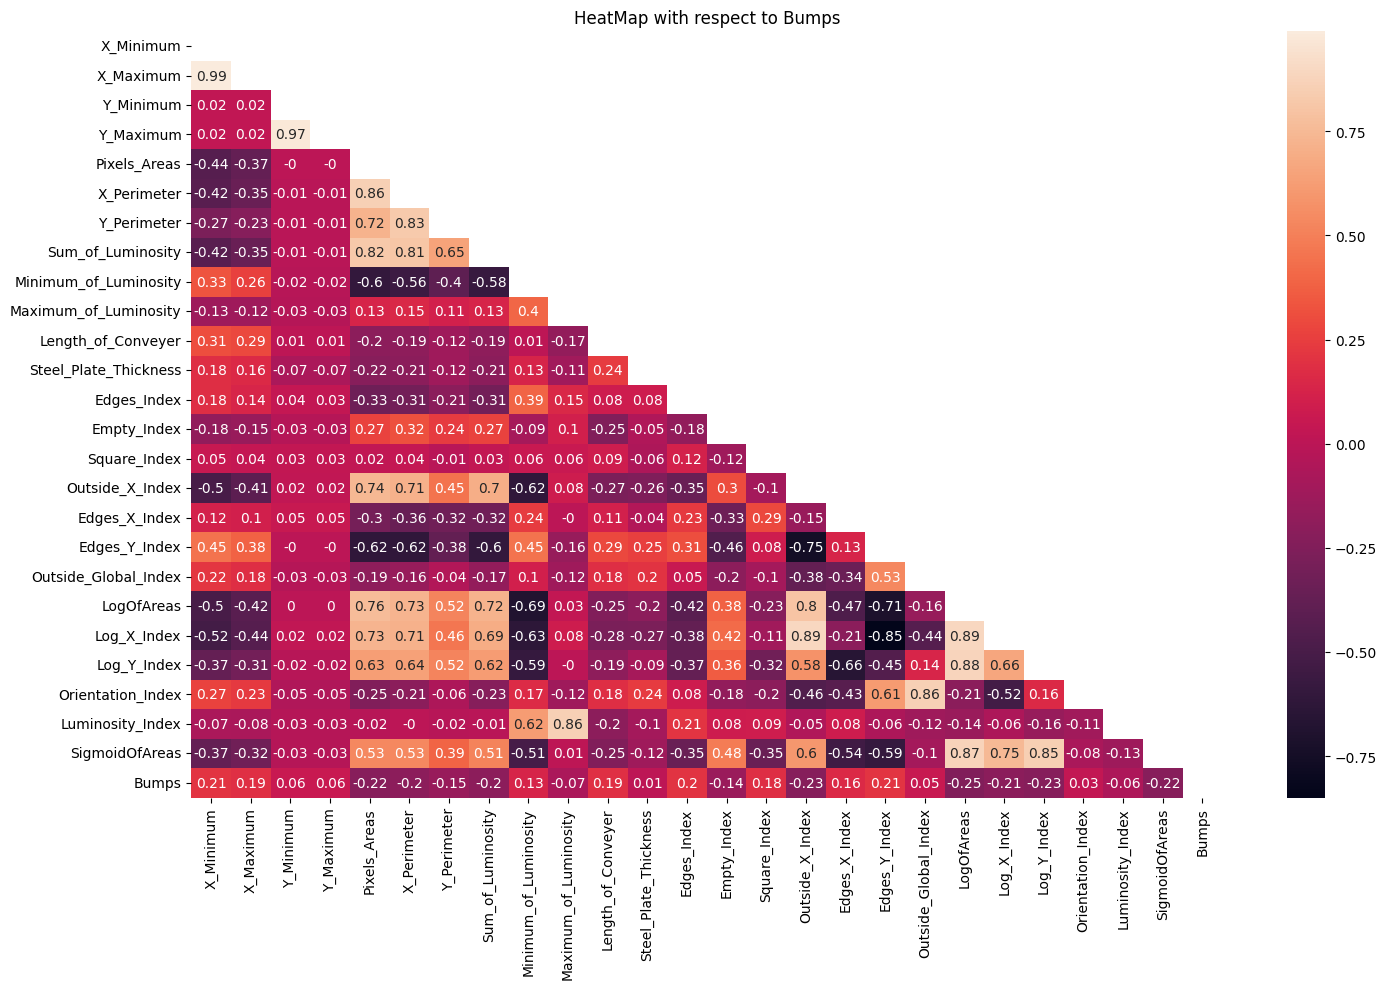

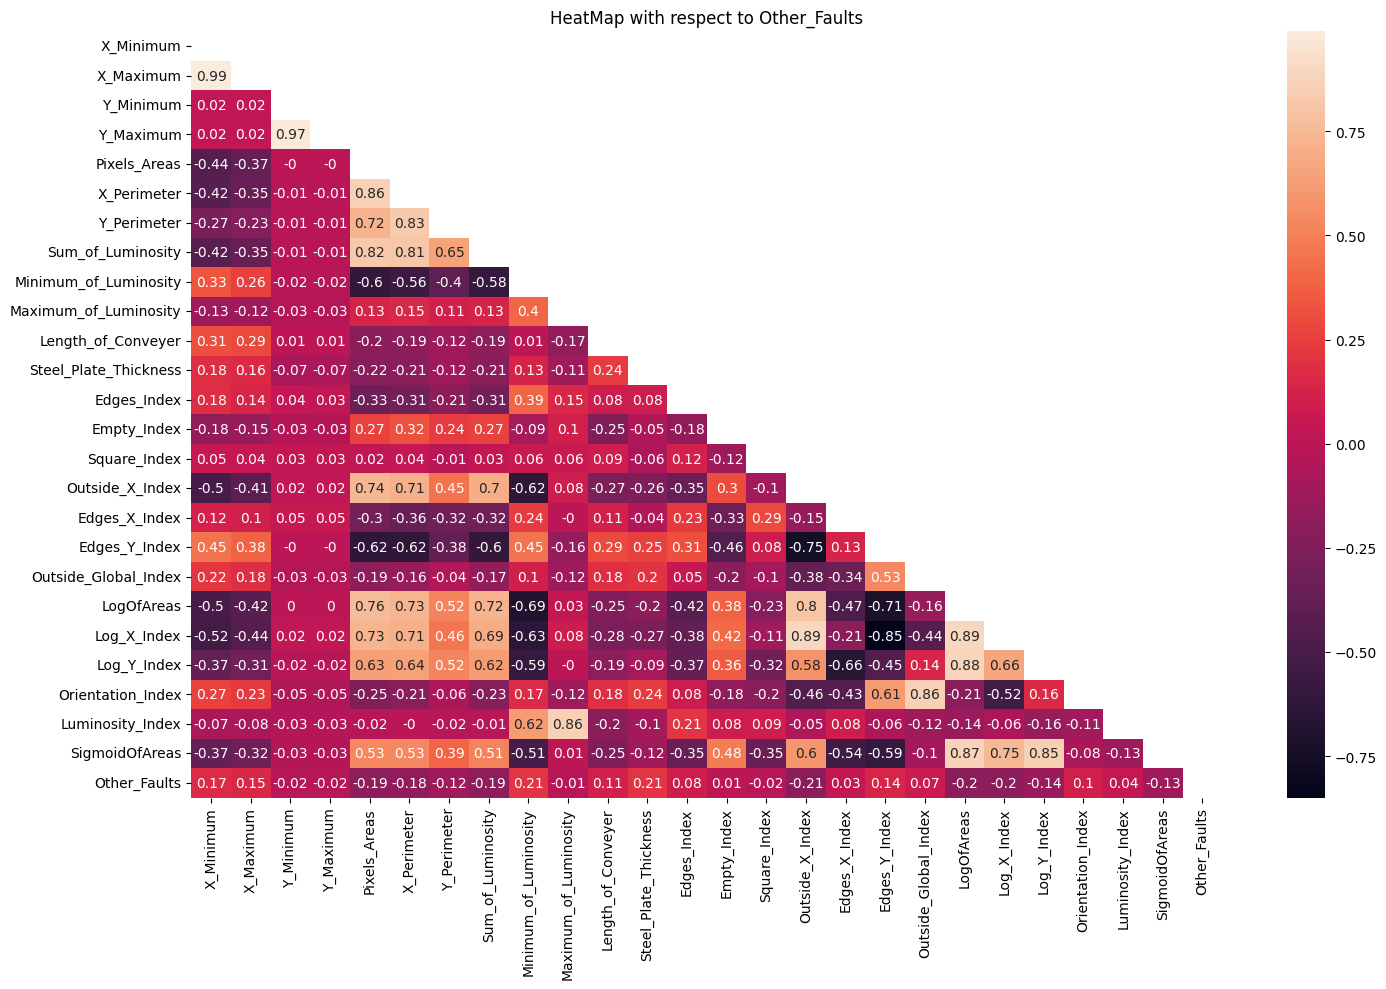

In [23]:
plot_corr(df_train_final,features)

# Key Takeaways: 
* X_Maximum and X_Minimum are highly correlated 
* Y_Maximum and Y_Minimum are highly correlated
* Pixel_Areas , X_Perimeter, Y_Perimeter ,Sum_Of_Luminosity,Outside_X_Index are highly correlated
* TypeOfSteel_A300 and TypeOfSteel_A400 are highly correlated (negatively)
* SigmoidOfAreas is correlated with LogOfAreas, Log_X_Index and Log_Y_Index
* Luminosity_Index is correlated with Maximum_Of_Luminosity
* Orientation_Index is correlated with Oustide_Global_Index
* LogofAreas is correlated with Log_X_Index and Log_Y_Index

# #3. Data Preprocessing

In [24]:
#df_train_final["X_Range"] = (df_train_final["X_Maximum"] - df_train_final["X_Minimum"])/(df_train_final["Outside_X_Index"] + 0.0000001)

#df_train_final["Y_Range"] = df_train_final["Y_Maximum"] - df_train_final["Y_Minimum"] 
df_train_final["X_Y_Range"]= (df_train_final["X_Maximum"] +  df_train_final["X_Minimum"] + df_train_final["Outside_X_Index"] )/(df_train_final["Y_Maximum"] + df_train_final["Y_Minimum"] + 0.00000001 )
df_train_final["Pixel_Area_Perimeter"] = df_train_final["Pixels_Areas"]/ (df_train_final["X_Perimeter"] + df_train_final["Y_Perimeter"])
#df_train_final["Type_of_Steel_Ratio"] = df_train_final["TypeOfSteel_A300"]- df_train_final["TypeOfSteel_A400"]
df_train_final["Log_Area_Index"] = df_train_final["LogOfAreas"]/(df_train_final["Log_X_Index"] + df_train_final["Log_Y_Index"])
df_train_final["Luminosity_Range"] = df_train_final["Maximum_of_Luminosity"] / (df_train_final["Luminosity_Index"]+ 0.0000001)
df_train_final["Orientation_Square_Index"]= df_train_final["Orientation_Index"]/ df_train_final["Square_Index"]
df_train_final["Edge_X_Y_Index"]= df_train_final["Edges_X_Index"] /(df_train_final["Edges_Y_Index"] + + 0.0000001)
#df_train_final['Sigmoid_outside_Global'] = 1 / (1 + np.exp(df_train_final['Outside_Global_Index'])) 

In [25]:
df_train_final_add=df_train_final.copy()
#features_delete=["X_Maximum","X_Minimum","Y_Maximum","Y_Minimum","Pixels_Areas","X_Perimeter","Y_Perimeter","TypeOfSteel_A300","TypeOfSteel_A400","LogOfAreas","Log_X_Index","Log_Y_Index","Maximum_of_Luminosity","Luminosity_Index","Orientation_Index","Outside_Global_Index","Square_Index"]
features_delete=["X_Maximum","X_Minimum","Y_Maximum","Y_Minimum","Pixels_Areas","X_Perimeter","Y_Perimeter","LogOfAreas","Log_X_Index","Log_Y_Index","Maximum_of_Luminosity","Luminosity_Index","Orientation_Index","Square_Index","Edges_Y_Index","Edges_X_Index","Outside_X_Index"]
df_train_final_add=df_train_final_add.drop(columns=features_delete)

In [26]:
df_test_final=df_test.copy()
#df_test_final["X_Range"] = (df_test_final["X_Maximum"] - df_test_final["X_Minimum"])/(df_test_final["Outside_X_Index"] + 0.0000001)
#df_test_final["Y_Range"] = df_test_final["Y_Maximum"] - df_test_final["Y_Minimum"] 
df_test_final["X_Y_Range"]= (df_test_final["X_Maximum"] +  df_test_final["X_Minimum"] + df_test_final["Outside_X_Index"] )/(df_test_final["Y_Maximum"] + df_test_final["Y_Minimum"] + 0.00000001 )

df_test_final["Pixel_Area_Perimeter"] = df_test_final["Pixels_Areas"]/ (df_test_final["X_Perimeter"] + df_test_final["Y_Perimeter"])
df_test_final['TypeOfSteel_A400'] = pd.Categorical(df_test_final.TypeOfSteel_A400)
df_test_final['TypeOfSteel_A300'] = pd.Categorical(df_test_final.TypeOfSteel_A300)

df_test_final["Log_Area_Index"] = df_test_final["LogOfAreas"]/(df_test_final["Log_X_Index"] + df_test_final["Log_Y_Index"])
df_test_final["Luminosity_Range"] = df_test_final["Maximum_of_Luminosity"] / (df_test_final["Luminosity_Index"]+ 0.0000001)
df_test_final["Orientation_Square_Index"]= df_test_final["Orientation_Index"]/ df_test_final["Square_Index"]
df_test_final["Edge_X_Y_Index"]= df_test_final["Edges_X_Index"] /(df_test_final["Edges_Y_Index"] + + 0.0000001)
#df_test_final['Sigmoid_outside_Global'] = 1 / (1 + np.exp(df_test_final['Outside_Global_Index']))
df_test_final=df_test_final.drop(columns=features_delete)

In [27]:
features= [c for c in df_train_final_add.columns.to_list() if c not in target and c not in df_categorical]
features

['Sum_of_Luminosity',
 'Minimum_of_Luminosity',
 'Length_of_Conveyer',
 'Steel_Plate_Thickness',
 'Edges_Index',
 'Empty_Index',
 'Outside_Global_Index',
 'SigmoidOfAreas',
 'X_Y_Range',
 'Pixel_Area_Perimeter',
 'Log_Area_Index',
 'Luminosity_Range',
 'Orientation_Square_Index',
 'Edge_X_Y_Index']

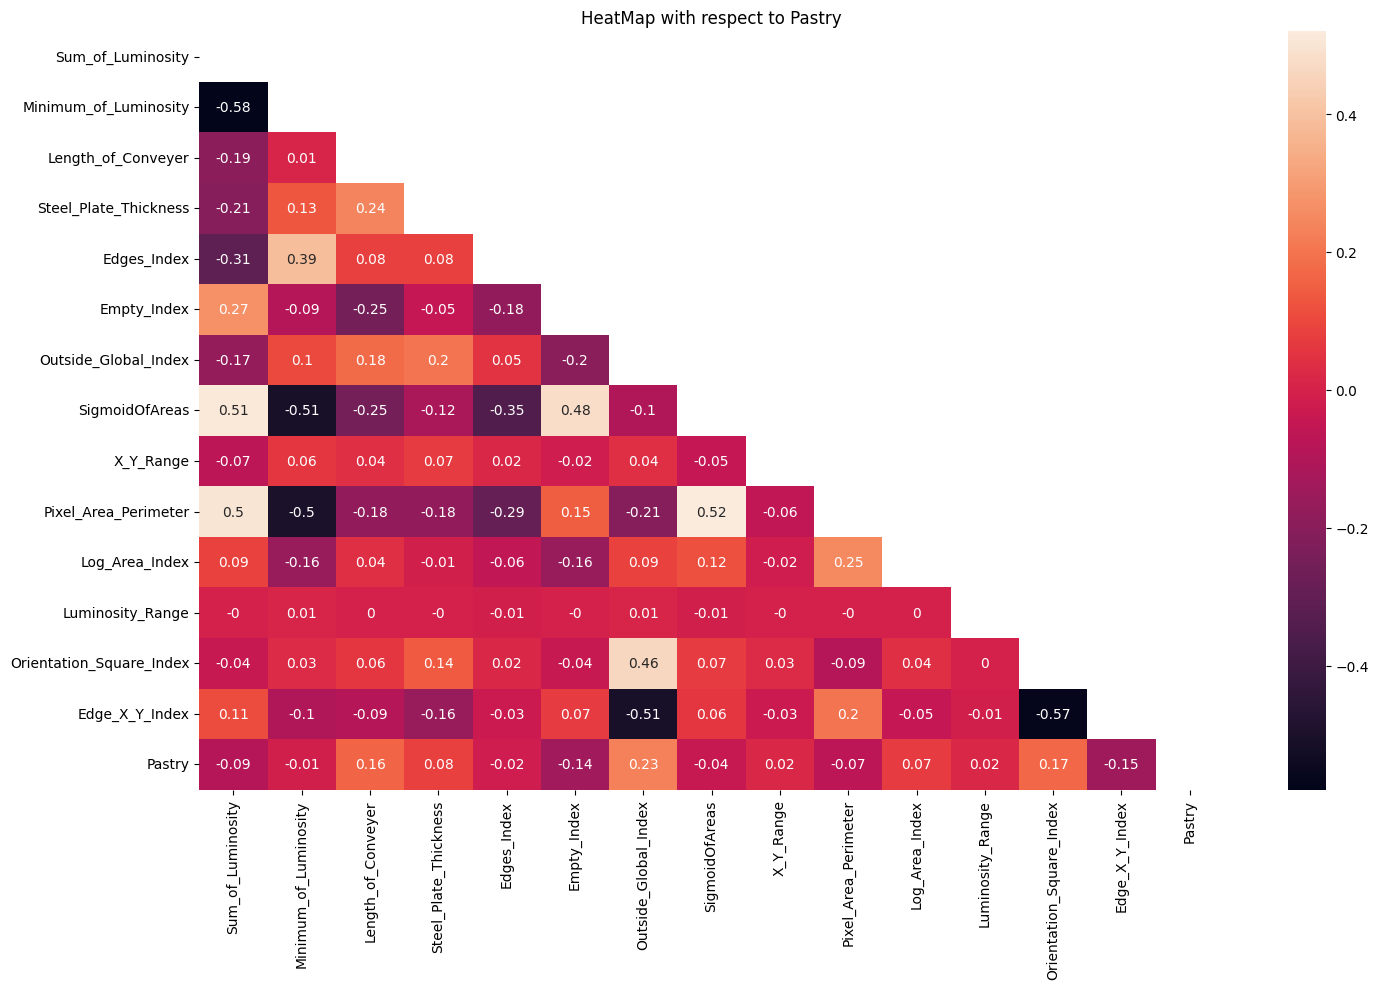

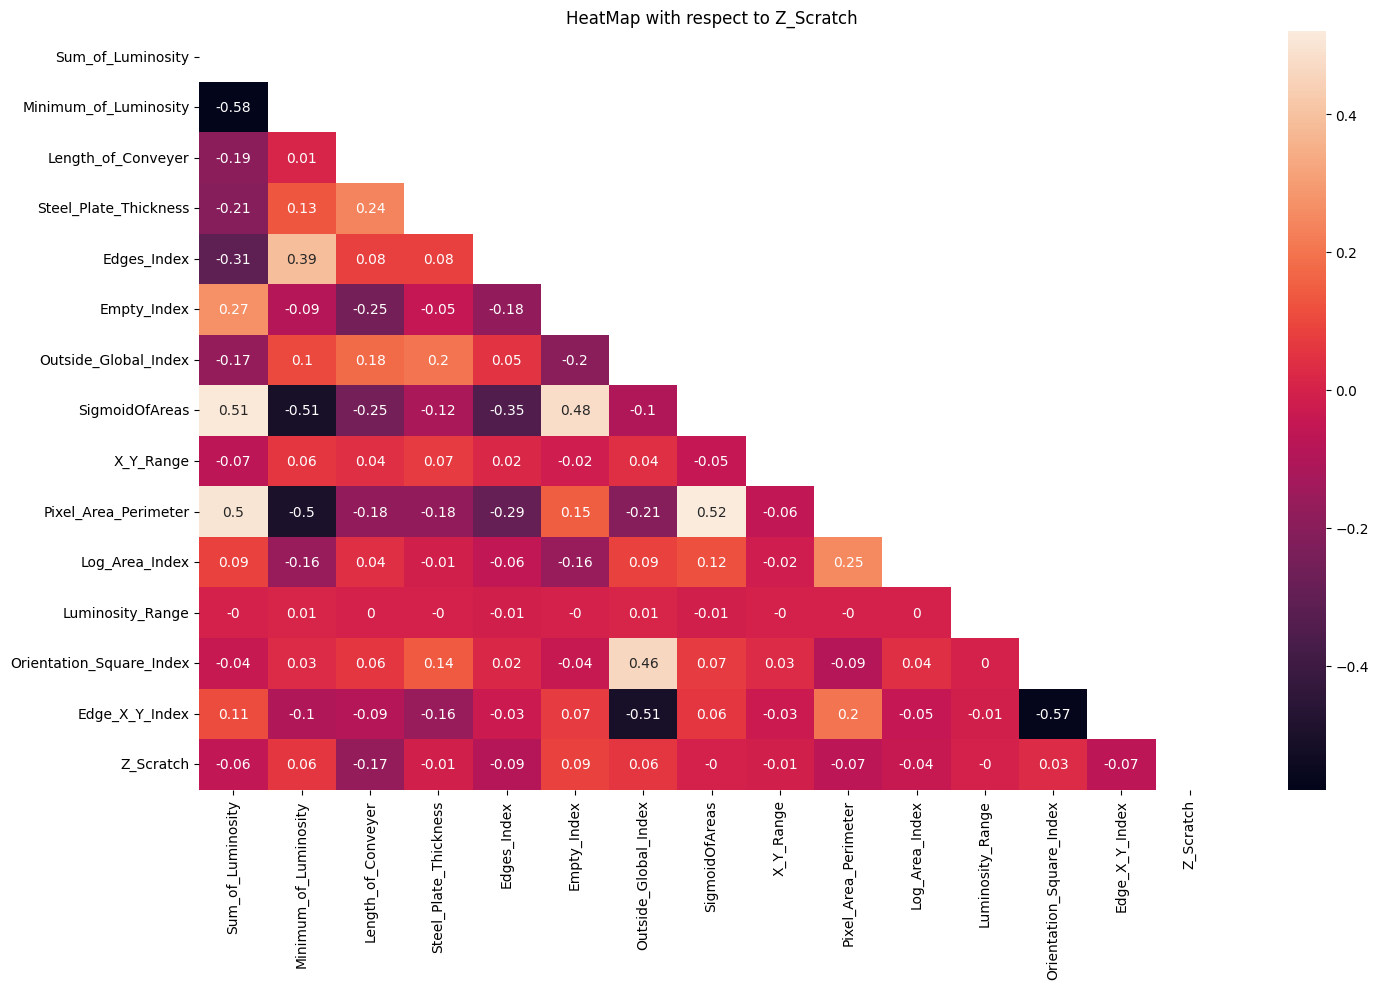

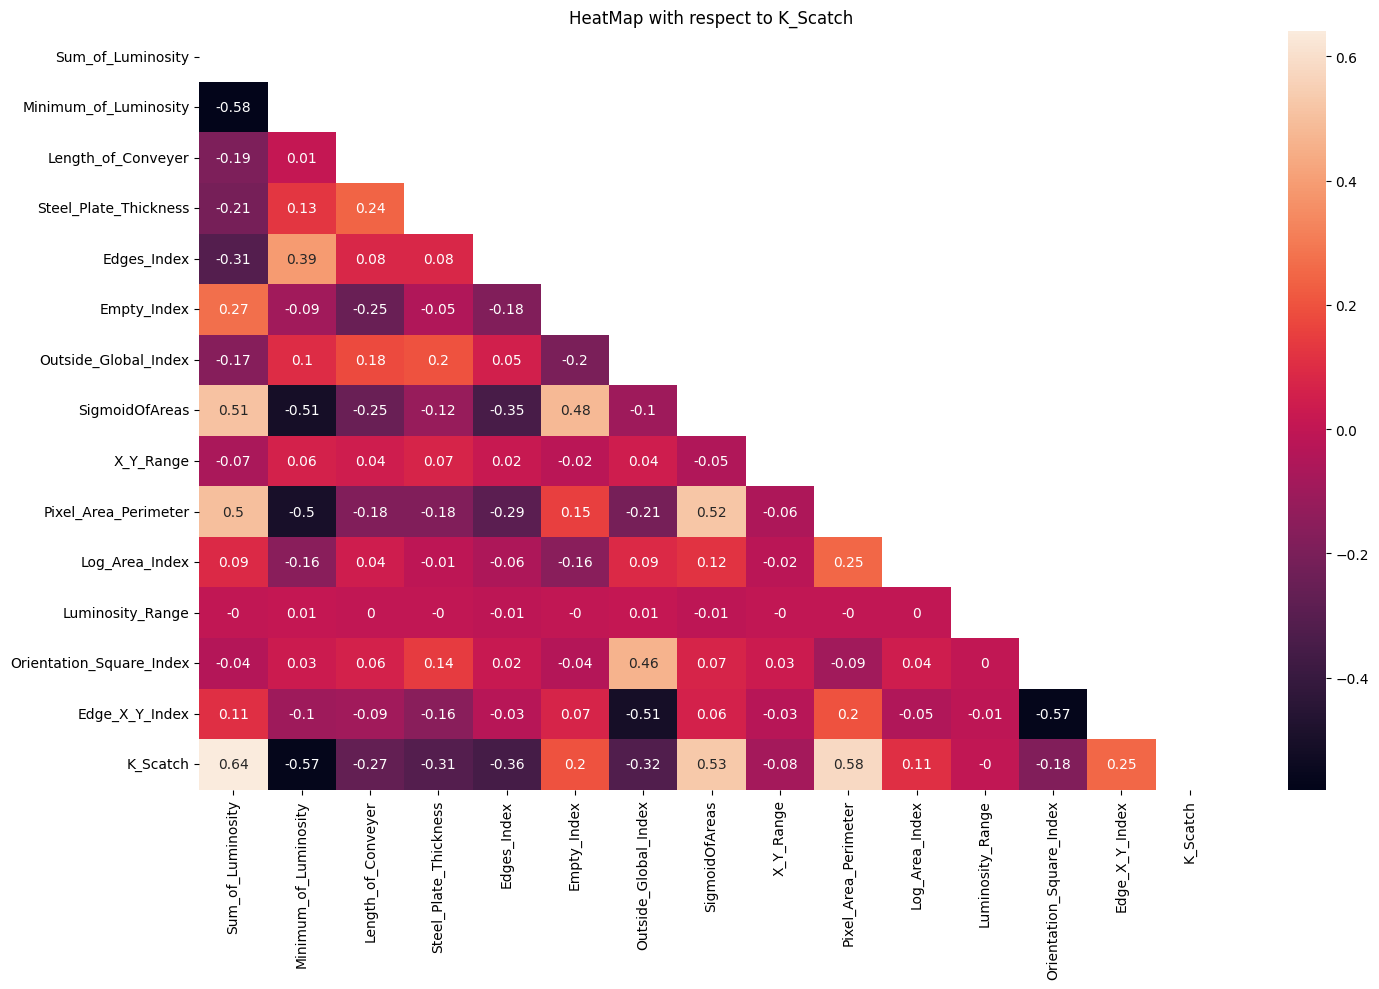

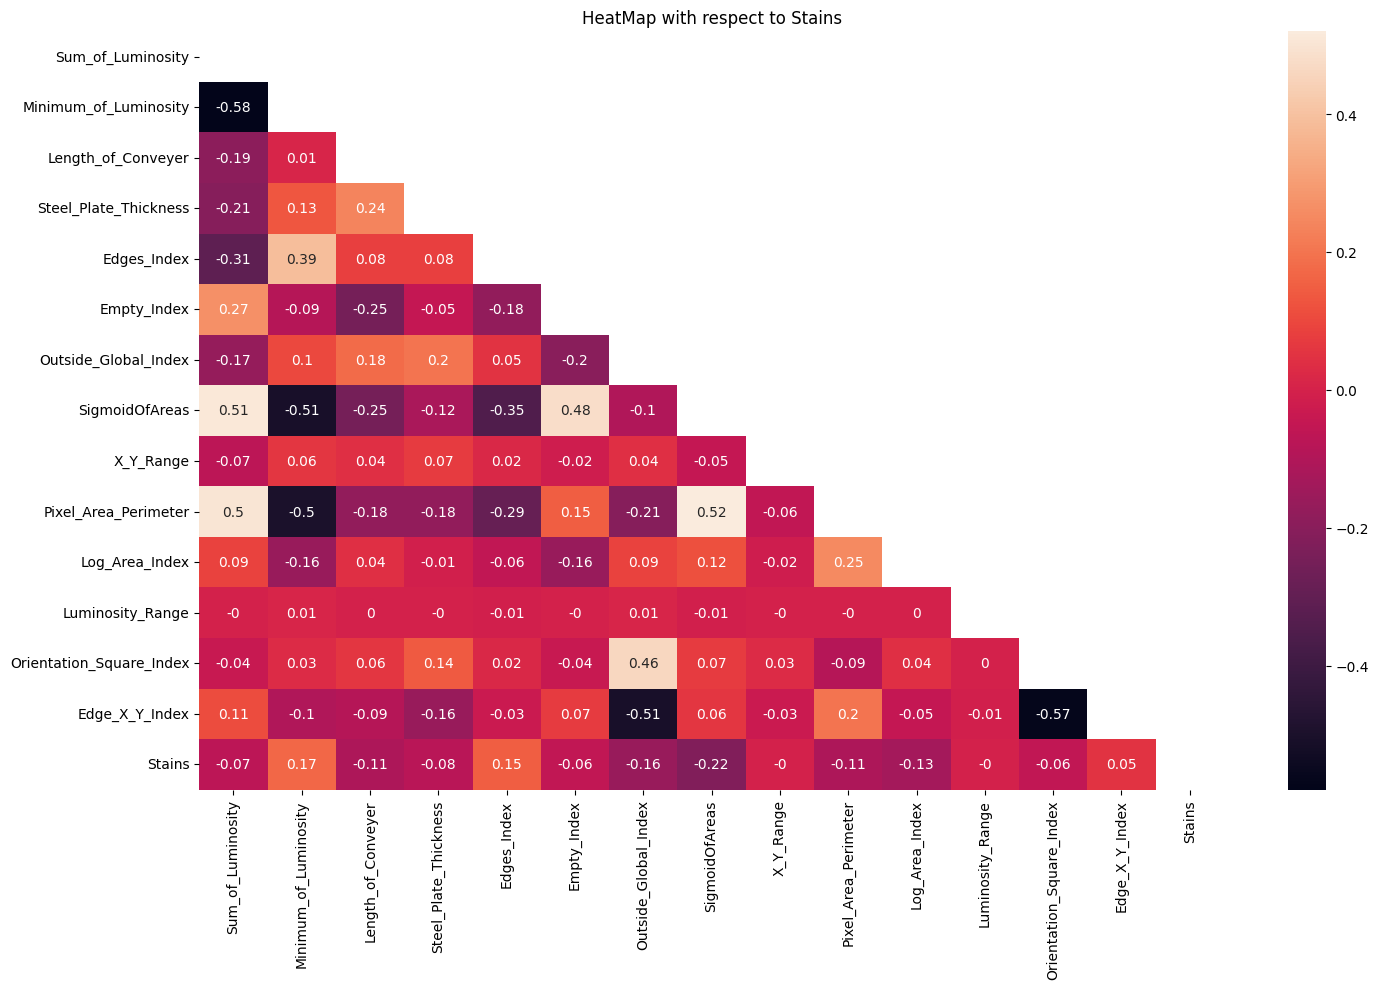

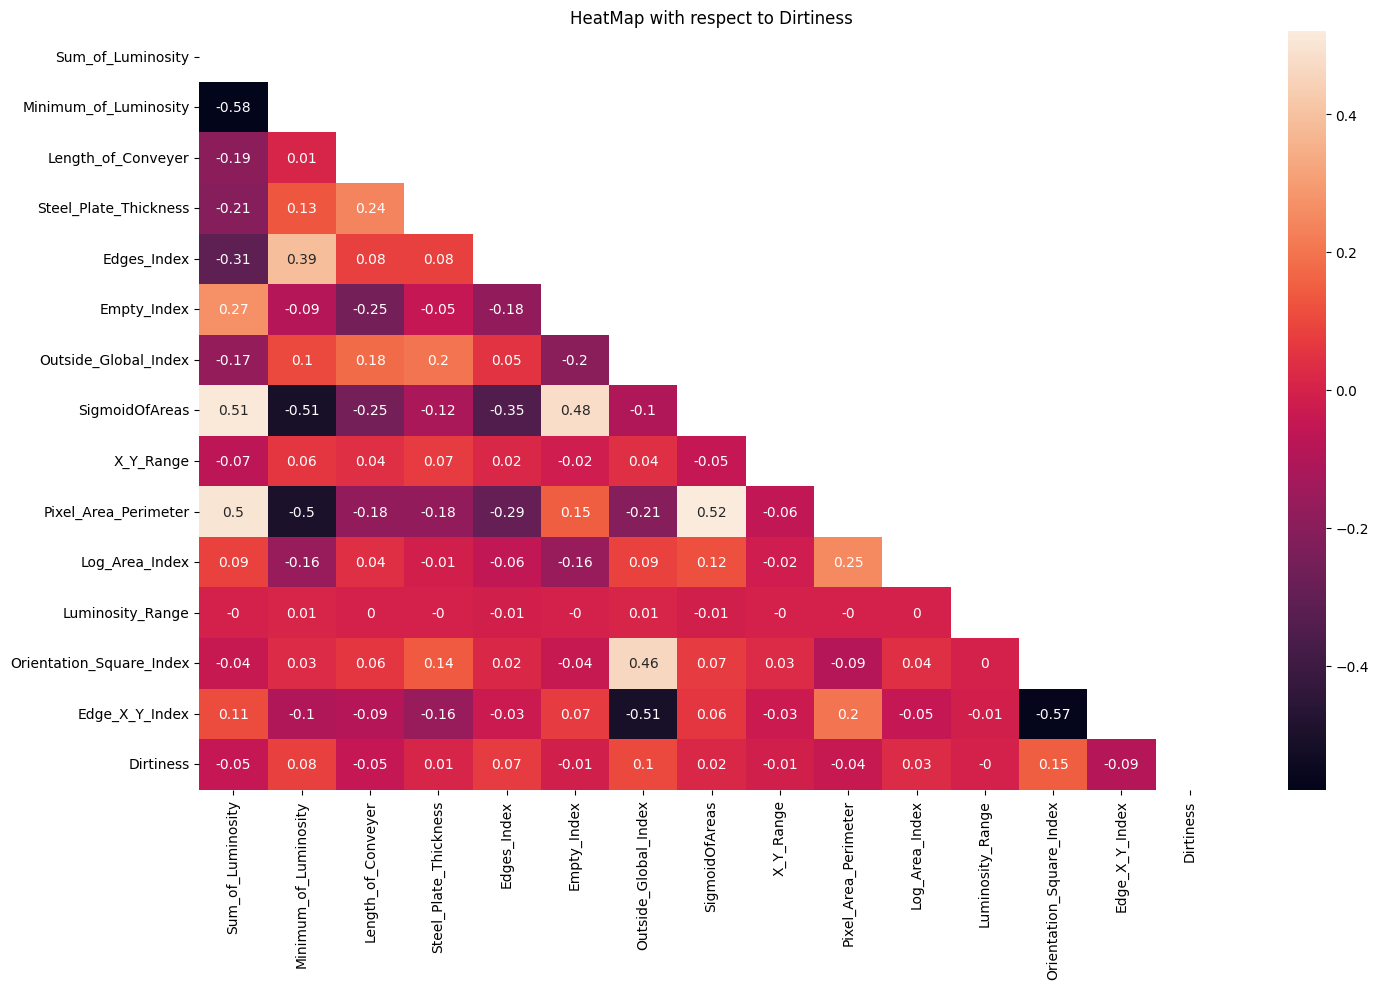

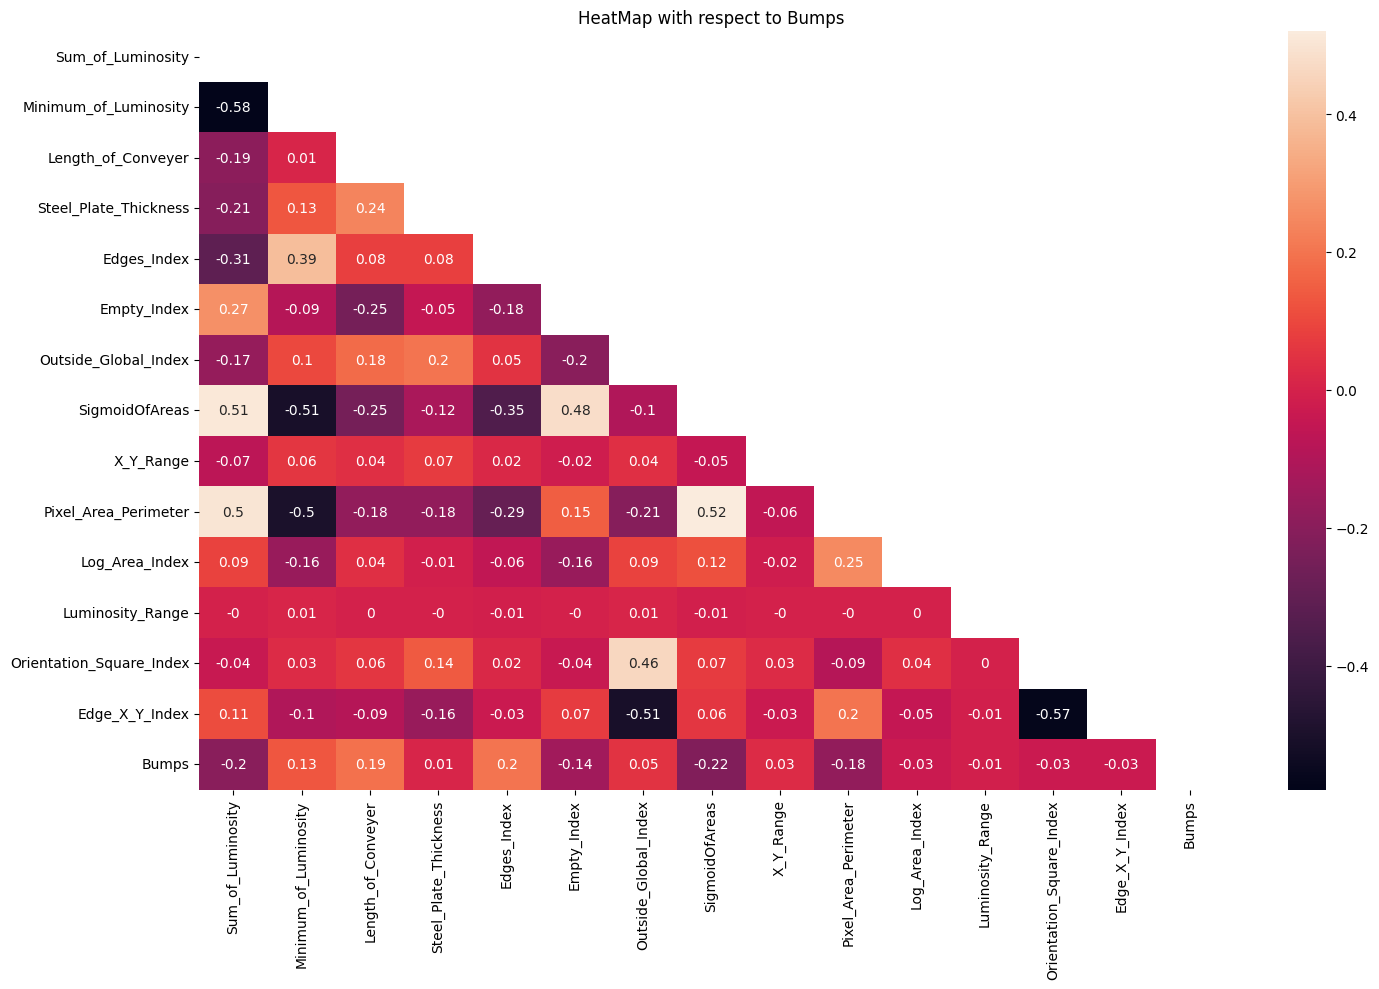

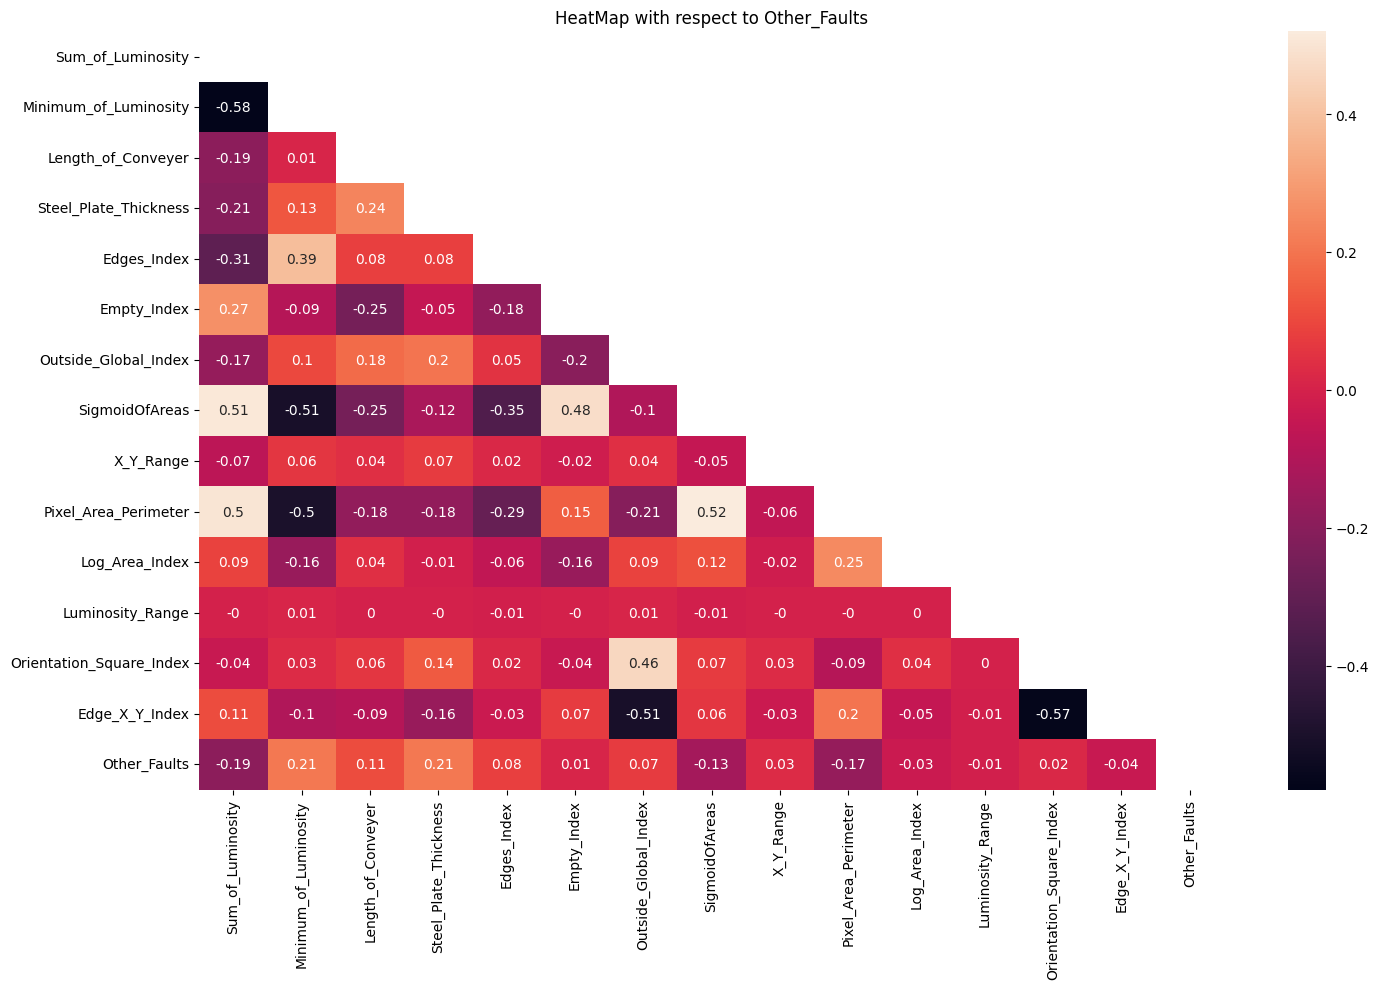

In [28]:
plot_corr(df_train_final_add, features)

In [29]:
def chi_squared_test(df, input_var, target_var, significance_level=0.05):
    contingency_table = pd.crosstab(df[input_var], df[target_var])
    chi2, p, _, _ = stats.chi2_contingency(contingency_table)
    
    if p < significance_level:
        print(f'{input_var} has a significant relationship with {target_var}') 
    else:
        print(f'{input_var} does not have a significant relationship with {target_var}') 

for t in target:
    print("\n")
    for c in  df_categorical:
        chi_squared_test(df_train_final_add, c, t)



TypeOfSteel_A300 does not have a significant relationship with Pastry
TypeOfSteel_A400 does not have a significant relationship with Pastry


TypeOfSteel_A300 has a significant relationship with Z_Scratch
TypeOfSteel_A400 has a significant relationship with Z_Scratch


TypeOfSteel_A300 has a significant relationship with K_Scatch
TypeOfSteel_A400 has a significant relationship with K_Scatch


TypeOfSteel_A300 has a significant relationship with Stains
TypeOfSteel_A400 has a significant relationship with Stains


TypeOfSteel_A300 has a significant relationship with Dirtiness
TypeOfSteel_A400 has a significant relationship with Dirtiness


TypeOfSteel_A300 has a significant relationship with Bumps
TypeOfSteel_A400 has a significant relationship with Bumps


TypeOfSteel_A300 has a significant relationship with Other_Faults
TypeOfSteel_A400 has a significant relationship with Other_Faults


In [30]:
features= [c for c in df_train_final_add.columns.to_list() if c not in target]
X=df_train_final_add[features]
numerical=X.select_dtypes(include=np.number).columns
categorical=X.select_dtypes(include="category").columns
numerical_preprocessor=Pipeline(steps=[('scaler',RobustScaler())])
cateogorical_preprocessor=Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])     
preprocessor=ColumnTransformer(transformers=[("num",numerical_preprocessor,numerical),("cat",cateogorical_preprocessor,categorical)])  

# #4. Hyperparameter Selection

In [31]:
#Optimzation for XGBoost Classifier
def objective(trial):
    params = {
            'max_depth': trial.suggest_int('max_depth', 3, 100),
             'num_leaves': trial.suggest_int('num_leaves', 20, 150),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
             'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
             'n_estimators': trial.suggest_int('n_estimators', 50, 2000, step=10),
             'subsample': trial.suggest_float('subsample', 0.5, 1.0),
             'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
            'boosting_type': trial.suggest_categorical('boosting_type', ['gbtree', 'dart']),
    }
    model = XGBClassifier(**params)
    pipeline=Pipeline([("transformer",RobustScaler()),("model",model)])

    score=cross_val_score(pipeline,X_train,y_train, scoring='f1_weighted', cv=5).mean()
    return score

"""bests={}
score={}
for t in range(6,len(target)):
    print(f"Stating Target:{t}--------------------------------------")
    y=df_train_final_add[target[t]]
    sss=StratifiedKFold(n_splits=5, shuffle=True)

    for i, (train_idx, test_idx) in enumerate(sss.split(X,y)):
        print(f"Trial :{i}---------------------------------------")
        X_train,X_test=X.iloc[train_idx], X.iloc[test_idx]
        y_train,y_test=y[train_idx],y[test_idx]    
        study=optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=20)
        bests[f"For the target : {t} the best for fold {i} with best value:{study.best_value}"] = study.best_params
        params=study.best_params
        model = XGBClassifier(**params)
        pipeline=Pipeline(steps=[("preprocessor",preprocessor),("model",model)])
        pipeline.fit(X_train, y_train)

        #Evaluate the model
        y_pred=pipeline.predict(X_test)
        cv_score=f1_score(y_pred,y_test,average="weighted")
        score[f"Score for the target : {t} for the fold {i} with best value: {study.best_value}"] = cv_score
    print(f"Best Params Results for target :{t}  : {bests}")    
    print(f"Best Score Results for target :{t}  : {score}") """

'bests={}\nscore={}\nfor t in range(6,len(target)):\n    print(f"Stating Target:{t}--------------------------------------")\n    y=df_train_final_add[target[t]]\n    sss=StratifiedKFold(n_splits=5, shuffle=True)\n\n    for i, (train_idx, test_idx) in enumerate(sss.split(X,y)):\n        print(f"Trial :{i}---------------------------------------")\n        X_train,X_test=X.iloc[train_idx], X.iloc[test_idx]\n        y_train,y_test=y[train_idx],y[test_idx]    \n        study=optuna.create_study(direction="maximize")\n        study.optimize(objective, n_trials=20)\n        bests[f"For the target : {t} the best for fold {i} with best value:{study.best_value}"] = study.best_params\n        params=study.best_params\n        model = XGBClassifier(**params)\n        pipeline=Pipeline(steps=[("preprocessor",preprocessor),("model",model)])\n        pipeline.fit(X_train, y_train)\n\n        #Evaluate the model\n        y_pred=pipeline.predict(X_test)\n        cv_score=f1_score(y_pred,y_test,average=

In [32]:
#Optimization for CatBoost
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000, step=10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
         'depth': trial.suggest_int('depth', 3, 10),
         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
         'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
         'verbose': False,
         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0, 1)
    }
    model = CatBoostClassifier(**params)
    pipeline=Pipeline([("transformer",RobustScaler()),("model",model)])

    score=cross_val_score(pipeline,X_train,y_train, scoring='f1_weighted', cv=5).mean()
    return score
"""bests={}
score={}
for t in range(len(target)):
    print(f"Stating Target:{t} ---------------------------------------------------\n")
    y=df_train_final_add[target[t]]
    sss=StratifiedKFold(n_splits=5, shuffle=True)

    for i, (train_idx, test_idx) in enumerate(sss.split(X,y)):
        X_train,X_test=X.iloc[train_idx], X.iloc[test_idx]
        y_train,y_test=y[train_idx],y[test_idx]    
        study=optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=20)
        bests[f"For the target : {t} the best for fold {i} with best value:{study.best_value}"] = study.best_params
        params=study.best_params
        model = CatBoostClassifier(**params)
        pipeline=Pipeline(steps=[("preprocessor",preprocessor),("model",model)])
        pipeline.fit(X_train, y_train)

        #Evaluate the model
        y_pred=pipeline.predict(X_test)
        cv_score=f1_score(y_pred,y_test,average="weighted")
        score[f"Score for the target : {t} for the fold {i} with best value: {study.best_value}"] = cv_score
    print(f"Best Params Results for target :{t}  : {bests}")    
    print(f"Best Score Results for target :{t}  : {score}")  """

'bests={}\nscore={}\nfor t in range(len(target)):\n    print(f"Stating Target:{t} ---------------------------------------------------\n")\n    y=df_train_final_add[target[t]]\n    sss=StratifiedKFold(n_splits=5, shuffle=True)\n\n    for i, (train_idx, test_idx) in enumerate(sss.split(X,y)):\n        X_train,X_test=X.iloc[train_idx], X.iloc[test_idx]\n        y_train,y_test=y[train_idx],y[test_idx]    \n        study=optuna.create_study(direction="maximize")\n        study.optimize(objective, n_trials=20)\n        bests[f"For the target : {t} the best for fold {i} with best value:{study.best_value}"] = study.best_params\n        params=study.best_params\n        model = CatBoostClassifier(**params)\n        pipeline=Pipeline(steps=[("preprocessor",preprocessor),("model",model)])\n        pipeline.fit(X_train, y_train)\n\n        #Evaluate the model\n        y_pred=pipeline.predict(X_test)\n        cv_score=f1_score(y_pred,y_test,average="weighted")\n        score[f"Score for the target 

In [33]:
def objective(trial):
    params = {
         'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
         'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100)
    }
    model = LGBMClassifier(**params)
    pipeline=Pipeline([("transformer",RobustScaler()),("model",model)])

    score=cross_val_score(pipeline,X_train,y_train, scoring='f1_weighted', cv=5).mean()
    return score
"""bests={}
score={}
for t in range(len(target)):
    print(f"Stating Target:{t} ---------------------------------------------------\n")
    y=df_train_final_add[target[t]]
    sss=StratifiedKFold(n_splits=5, shuffle=True)

    for i, (train_idx, test_idx) in enumerate(sss.split(X,y)):
        X_train,X_test=X.iloc[train_idx], X.iloc[test_idx]
        y_train,y_test=y[train_idx],y[test_idx]    
        study=optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=20)
        bests[f"For the target : {t} the best for fold {i} with best value:{study.best_value}"] = study.best_params
        params=study.best_params
        model = LGBMClassifier(**params)
        pipeline=Pipeline(steps=[("preprocessor",preprocessor),("model",model)])
        pipeline.fit(X_train, y_train)

        #Evaluate the model
        y_pred=pipeline.predict(X_test)
        cv_score=f1_score(y_pred,y_test,average="weighted")
        score[f"Score for the target : {t} for the fold {i} with best value: {study.best_value}"] = cv_score
    print(f"Best Params Results for target :{t}  : {bests}")    
    print(f"Best Score Results for target :{t}  : {score}")   """

'bests={}\nscore={}\nfor t in range(len(target)):\n    print(f"Stating Target:{t} ---------------------------------------------------\n")\n    y=df_train_final_add[target[t]]\n    sss=StratifiedKFold(n_splits=5, shuffle=True)\n\n    for i, (train_idx, test_idx) in enumerate(sss.split(X,y)):\n        X_train,X_test=X.iloc[train_idx], X.iloc[test_idx]\n        y_train,y_test=y[train_idx],y[test_idx]    \n        study=optuna.create_study(direction="maximize")\n        study.optimize(objective, n_trials=20)\n        bests[f"For the target : {t} the best for fold {i} with best value:{study.best_value}"] = study.best_params\n        params=study.best_params\n        model = LGBMClassifier(**params)\n        pipeline=Pipeline(steps=[("preprocessor",preprocessor),("model",model)])\n        pipeline.fit(X_train, y_train)\n\n        #Evaluate the model\n        y_pred=pipeline.predict(X_test)\n        cv_score=f1_score(y_pred,y_test,average="weighted")\n        score[f"Score for the target : {t

XgBoost Classifier

In [34]:
folds_param_dict_xgb={}

In [35]:
params_dict={}
params_dict[0]={'max_depth': 43, 'num_leaves': 98, 'reg_alpha': 0.8707536297338393, 'reg_lambda': 0.7310867025093805, 'learning_rate': 0.2839331789033391, 'n_estimators': 630, 'subsample': 0.8706063631262985, 'colsample_bytree': 0.8496009712445629, 'boosting_type': 'dart'}
params_dict[1]= {'max_depth': 34, 'num_leaves': 84, 'reg_alpha': 0.9919006193782401, 'reg_lambda': 0.3364975664869645, 'learning_rate': 0.29254419817302635, 'n_estimators': 1300, 'subsample': 0.6326914072363654, 'colsample_bytree': 0.8075303875303129, 'boosting_type': 'gbtree'}
params_dict[2]= {'max_depth': 27, 'num_leaves': 106, 'reg_alpha': 0.11620058027121016, 'reg_lambda': 0.8676061982686023, 'learning_rate': 0.29243741425587333, 'n_estimators': 1740, 'subsample': 0.565590822895391, 'colsample_bytree': 0.924029268359472, 'boosting_type': 'dart'}
params_dict[3]=  {'max_depth': 4, 'num_leaves': 39, 'reg_alpha': 0.9617951720934608, 'reg_lambda': 0.6579056917222035, 'learning_rate': 0.07665143607593836, 'n_estimators': 710, 'subsample': 0.6248961086105118, 'colsample_bytree': 0.2854308039486136, 'boosting_type': 'gbtree'}
params_dict[4]= {'max_depth': 3, 'num_leaves': 150, 'reg_alpha': 0.6821137862507187, 'reg_lambda': 0.3356566636175645, 'learning_rate': 0.24799292016358437, 'n_estimators': 1070, 'subsample': 0.7739391174454847, 'colsample_bytree': 0.9866843033595731, 'boosting_type': 'gbtree'}
folds_param_dict_xgb[target[0]]= params_dict

In [36]:
params_dict={}
params_dict[0]={'max_depth': 14, 'num_leaves': 85, 'reg_alpha': 0.635327288690343, 'reg_lambda': 0.8104114985415096, 'learning_rate': 0.19907907184446189, 'n_estimators': 200, 'subsample': 0.7732212860671654, 'colsample_bytree': 0.754029592904722, 'boosting_type': 'dart'}
params_dict[1]={'max_depth': 29, 'num_leaves': 106, 'reg_alpha': 0.40293708769705233, 'reg_lambda': 0.9957180704876694, 'learning_rate': 0.015518242707816057, 'n_estimators': 930, 'subsample': 0.655399838815147, 'colsample_bytree': 0.9751047702851864, 'boosting_type': 'gbtree'} 
params_dict[2]={'max_depth': 43, 'num_leaves': 53, 'reg_alpha': 0.3960784039440722, 'reg_lambda': 0.6979919269966501, 'learning_rate': 0.055503559164615315, 'n_estimators': 600, 'subsample': 0.988867437116505, 'colsample_bytree': 0.9955603374976194, 'boosting_type': 'gbtree'} 
params_dict[3]={'max_depth': 67, 'num_leaves': 63, 'reg_alpha': 0.7250649861607894, 'reg_lambda': 0.2537287327032908, 'learning_rate': 0.20561938225597218, 'n_estimators': 80, 'subsample': 0.9903944946147879, 'colsample_bytree': 0.9930782606861674, 'boosting_type': 'dart'}
params_dict[4]={'max_depth': 24, 'num_leaves': 148, 'reg_alpha': 0.8012699436172466, 'reg_lambda': 0.5046660029551507, 'learning_rate': 0.2982385976320675, 'n_estimators': 1350, 'subsample': 0.8509591340442193, 'colsample_bytree': 0.9834703003522537, 'boosting_type': 'gbtree'}

folds_param_dict_xgb[target[1]]= params_dict

In [37]:
params_dict={}
params_dict[0]={'max_depth': 37, 'num_leaves': 27, 'reg_alpha': 0.318022312387846, 'reg_lambda': 0.7274967860098166, 'learning_rate': 0.019192350271832546, 'n_estimators': 1130, 'subsample': 0.6390613810997864, 'colsample_bytree': 0.36853854138056996, 'boosting_type': 'dart'}
params_dict[1]={'max_depth': 3, 'num_leaves': 146, 'reg_alpha': 0.5543140006384474, 'reg_lambda': 0.824198059849736, 'learning_rate': 0.02320844095364762, 'n_estimators': 1950, 'subsample': 0.802036447148276, 'colsample_bytree': 0.6922526967071341, 'boosting_type': 'gbtree'}
params_dict[2]={'max_depth': 100, 'num_leaves': 55, 'reg_alpha': 0.42871561461100816, 'reg_lambda': 0.036359307865273145, 'learning_rate': 0.01255945636451447, 'n_estimators': 1990, 'subsample': 0.5100901719971763, 'colsample_bytree': 0.387097104392086, 'boosting_type': 'gbtree'} 
params_dict[3]={'max_depth': 21, 'num_leaves': 106, 'reg_alpha': 0.19397155570961086, 'reg_lambda': 0.7251339099143206, 'learning_rate': 0.011361266045833871, 'n_estimators': 1300, 'subsample': 0.9321836687128857, 'colsample_bytree': 0.5699444399216628, 'boosting_type': 'dart'}
params_dict[4]={'max_depth': 57, 'num_leaves': 84, 'reg_alpha': 0.8595667140150359, 'reg_lambda': 0.7711369365983727, 'learning_rate': 0.010171950293331431, 'n_estimators': 1110, 'subsample': 0.9778445378928997, 'colsample_bytree': 0.43931724511133297, 'boosting_type': 'dart'}

folds_param_dict_xgb[target[2]]= params_dict

In [38]:
params_dict={}
params_dict[0]={'max_depth': 61, 'num_leaves': 56, 'reg_alpha': 0.6039102417864177, 'reg_lambda': 0.9356382204005231, 'learning_rate': 0.20604197749343445, 'n_estimators': 1810, 'subsample': 0.8846961759178054, 'colsample_bytree': 0.5236140817291854, 'boosting_type': 'gbtree'}
params_dict[1]={'max_depth': 3, 'num_leaves': 106, 'reg_alpha': 0.989412902645159, 'reg_lambda': 0.9908624629848597, 'learning_rate': 0.17889477442846388, 'n_estimators': 100, 'subsample': 0.9869281805682842, 'colsample_bytree': 0.9904307980321243, 'boosting_type': 'dart'}
params_dict[2]={'max_depth': 11, 'num_leaves': 70, 'reg_alpha': 0.6055679252998634, 'reg_lambda': 0.8042472906078706, 'learning_rate': 0.051719741813220504, 'n_estimators': 510, 'subsample': 0.9501459783629863, 'colsample_bytree': 0.9984057213251765, 'boosting_type': 'gbtree'}
params_dict[3]={'max_depth': 23, 'num_leaves': 110, 'reg_alpha': 0.22758876811779483, 'reg_lambda': 0.8995064425176262, 'learning_rate': 0.1276470089946372, 'n_estimators': 1530, 'subsample': 0.8522785443321783, 'colsample_bytree': 0.4357351449403719, 'boosting_type': 'gbtree'}
params_dict[4]={'max_depth': 23, 'num_leaves': 110, 'reg_alpha': 0.22758876811779483, 'reg_lambda': 0.8995064425176262, 'learning_rate': 0.1276470089946372, 'n_estimators': 1530, 'subsample': 0.8522785443321783, 'colsample_bytree': 0.4357351449403719, 'boosting_type': 'gbtree'}

folds_param_dict_xgb[target[3]]= params_dict

In [39]:
params_dict={}

params_dict[0]={'max_depth': 55, 'num_leaves': 93, 'reg_alpha': 0.875035560046493, 'reg_lambda': 0.6609113278690845, 'learning_rate': 0.07251132330667184, 'n_estimators': 1570, 'subsample': 0.605453052537826, 'colsample_bytree': 0.9068080025952708, 'boosting_type': 'gbtree'}
params_dict[1]={'max_depth': 87, 'num_leaves': 35, 'reg_alpha': 0.7213836276721727, 'reg_lambda': 0.9748252874080237, 'learning_rate': 0.06753418020978648, 'n_estimators': 1770, 'subsample': 0.9196146492078555, 'colsample_bytree': 0.8551832548688936, 'boosting_type': 'gbtree'} 
params_dict[2]={'max_depth': 5, 'num_leaves': 109, 'reg_alpha': 0.3144266442157359, 'reg_lambda': 0.18101135692615988, 'learning_rate': 0.2154166968376356, 'n_estimators': 1500, 'subsample': 0.5980280480154494, 'colsample_bytree': 0.5489519111769973, 'boosting_type': 'gbtree'} 
params_dict[3]={'max_depth': 97, 'num_leaves': 41, 'reg_alpha': 0.7278373462839474, 'reg_lambda': 0.6037869513746367, 'learning_rate': 0.09063726242970002, 'n_estimators': 1490, 'subsample': 0.8525271083125213, 'colsample_bytree': 0.7122436280129548, 'boosting_type': 'dart'}
params_dict[4]={'max_depth': 33, 'num_leaves': 81, 'reg_alpha': 0.6029109507180327, 'reg_lambda': 0.24714034014711628, 'learning_rate': 0.07536505663170319, 'n_estimators': 1770, 'subsample': 0.5420408123519286, 'colsample_bytree': 0.944451746477009, 'boosting_type': 'dart'}

folds_param_dict_xgb[target[4]]= params_dict

In [40]:
params_dict={}
params_dict[0]={'max_depth': 9, 'num_leaves': 28, 'reg_alpha': 0.4604635473944738, 'reg_lambda': 0.6325454459116466, 'learning_rate': 0.01778997372675135, 'n_estimators': 960, 'subsample': 0.6744838632986316, 'colsample_bytree': 0.9265317695833681, 'boosting_type': 'gbtree'} 
params_dict[1]={'max_depth': 10, 'num_leaves': 68, 'reg_alpha': 0.6387810789208115, 'reg_lambda': 0.9686867529502826, 'learning_rate': 0.01733279280002752, 'n_estimators': 1530, 'subsample': 0.5367863809927117, 'colsample_bytree': 0.3054940365964702, 'boosting_type': 'gbtree'} 
params_dict[2]={'max_depth': 73, 'num_leaves': 26, 'reg_alpha': 0.5674013865808994, 'reg_lambda': 0.506457405281875, 'learning_rate': 0.062168069461558124, 'n_estimators': 910, 'subsample': 0.8868910717323082, 'colsample_bytree': 0.7244076988370781, 'boosting_type': 'dart'}
params_dict[3]={'max_depth': 5, 'num_leaves': 28, 'reg_alpha': 0.6541500933273342, 'reg_lambda': 0.31454458483005887, 'learning_rate': 0.010435521091071627, 'n_estimators': 790, 'subsample': 0.5132461268965939, 'colsample_bytree': 0.9914709409693174, 'boosting_type': 'gbtree'} 
params_dict[4]={'max_depth': 76, 'num_leaves': 21, 'reg_alpha': 0.7122421538484124, 'reg_lambda': 0.21547387521838712, 'learning_rate': 0.05971226761351562, 'n_estimators': 590, 'subsample': 0.869670328823185, 'colsample_bytree': 0.7269189334934727, 'boosting_type': 'gbtree'}

folds_param_dict_xgb[target[5]]= params_dict

In [41]:
params_dict={}

params_dict[0]= {'max_depth': 3, 'num_leaves': 38, 'reg_alpha': 0.9753108511765554, 'reg_lambda': 0.9775872102431957, 'learning_rate': 0.20567032261224996, 'n_estimators': 870, 'subsample': 0.8428622966237137, 'colsample_bytree': 0.13744841713195022, 'boosting_type': 'dart'}
params_dict[1]={'max_depth': 30, 'num_leaves': 92, 'reg_alpha': 0.7209590990290751, 'reg_lambda': 0.6485504783441598, 'learning_rate': 0.0653064362353082, 'n_estimators': 140, 'subsample': 0.8508382365077554, 'colsample_bytree': 0.8676391892554169, 'boosting_type': 'gbtree'} 
params_dict[2]={'max_depth': 3, 'num_leaves': 123, 'reg_alpha': 0.8406665501331928, 'reg_lambda': 0.1823254893456686, 'learning_rate': 0.20709399345869609, 'n_estimators': 440, 'subsample': 0.9158498076568602, 'colsample_bytree': 0.8774039489692838, 'boosting_type': 'gbtree'} 
params_dict[3]={'max_depth': 4, 'num_leaves': 51, 'reg_alpha': 0.9773620731755217, 'reg_lambda': 0.4669813262505713, 'learning_rate': 0.055509660861444377, 'n_estimators': 1410, 'subsample': 0.6443499226094768, 'colsample_bytree': 0.22964777636141198, 'boosting_type': 'gbtree'} 
params_dict[4]={'max_depth': 4, 'num_leaves': 150, 'reg_alpha': 0.29605814368354305, 'reg_lambda': 0.6963510582162217, 'learning_rate': 0.06932112898516354, 'n_estimators': 1980, 'subsample': 0.958304873310734, 'colsample_bytree': 0.35054911942449646, 'boosting_type': 'dart'}

folds_param_dict_xgb[target[6]]= params_dict

In [42]:
features= [c for c in df_train_final_add.columns.to_list() if c not in target]
X=df_train_final_add[features]
X_test=df_test_final[features]


def predict_xgb(params,X,y,X_test):
    model = XGBClassifier(**params)
    pipeline=Pipeline(steps=[("preprocessor",preprocessor),("model",model)])
    pipeline.fit(X, y)
        
    #Evaluate the model
    y_pred_proba=pipeline.predict_proba(X_test)
    return y_pred_proba[:,1].tolist()

In [43]:
pred_df_xgb=pd.DataFrame(columns=target)
for t in target:
    y=df_train_final_add[t]
    params_dict=folds_param_dict_xgb[t]
    pred_prob=[]
    for i in range(len(params_dict)):
        params=params_dict[i]
        pred_prob.append(predict_xgb(params,X,y,X_test))
    pred_df_xgb[t] = [sum(i) for i in zip(*pred_prob)]
    pred_df_xgb[t] = np.divide(pred_df_xgb[t], len(pred_prob))

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:02:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "boosting_type", "num_leaves" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:02:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "boosting_type", "num_leaves" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:02:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "boosting_type", "num_leaves" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:02:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "boosting_type", "num_leaves" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:02:45] WARNING: /workspace/src/lea

LightGBM Classifier

In [44]:
folds_param_dict_lgbm={}

In [45]:
params_dict={}
params_dict[0]={'reg_alpha': 0.21879887242093193, 'reg_lambda': 0.04729677626094733, 'num_leaves': 23, 'n_estimators': 100, 'learning_rate': 0.11079223979573727, 'feature_fraction': 0.973714832068527, 'bagging_fraction': 0.4262123736061346, 'bagging_freq': 5, 'min_child_samples': 73} 
params_dict[1]={'reg_alpha': 0.7327208984111552, 'reg_lambda': 0.5772138015567628, 'num_leaves': 72, 'n_estimators': 800, 'learning_rate': 0.08749841294694714, 'feature_fraction': 0.9415511872337955, 'bagging_fraction': 0.5268786133763387, 'bagging_freq': 2, 'min_child_samples': 82}
params_dict[2]={'reg_alpha': 0.7207424296594845, 'reg_lambda': 0.18506292655006912, 'num_leaves': 105, 'n_estimators': 700, 'learning_rate': 0.1608948707719689, 'feature_fraction': 0.5795129607536124, 'bagging_fraction': 0.8537124835308959, 'bagging_freq': 4, 'min_child_samples': 59} 
params_dict[3]={'reg_alpha': 0.5330186572088579, 'reg_lambda': 0.36561668652822116, 'num_leaves': 5, 'n_estimators': 400, 'learning_rate': 0.17192767255909308, 'feature_fraction': 0.6051126059651857, 'bagging_fraction': 0.8023376491389801, 'bagging_freq': 2, 'min_child_samples': 53} 
params_dict[4]={'reg_alpha': 0.017143654168574662, 'reg_lambda': 0.1419947793309302, 'num_leaves': 26, 'n_estimators': 300, 'learning_rate': 0.15305357533251118, 'feature_fraction': 0.9689809943819153, 'bagging_fraction': 0.6316113101585, 'bagging_freq': 2, 'min_child_samples': 7}


folds_param_dict_lgbm[target[0]]= params_dict

In [46]:
params_dict={}
params_dict[0]={'reg_alpha': 0.9865705474995439, 'reg_lambda': 0.012183912439425182, 'num_leaves': 22, 'n_estimators': 500, 'learning_rate': 0.011618257415311712, 'feature_fraction': 0.7433162770758049, 'bagging_fraction': 0.8837311683377038, 'bagging_freq': 3, 'min_child_samples': 42} 
params_dict[1]= {'reg_alpha': 0.6139019472850724, 'reg_lambda': 0.0396870354871908, 'num_leaves': 42, 'n_estimators': 100, 'learning_rate': 0.06755211203023102, 'feature_fraction': 0.7348510963288044, 'bagging_fraction': 0.782270103464897, 'bagging_freq': 3, 'min_child_samples': 72} 
params_dict[2]={'reg_alpha': 0.796067823192782, 'reg_lambda': 0.6568560925097008, 'num_leaves': 95, 'n_estimators': 400, 'learning_rate': 0.010891585553386865, 'feature_fraction': 0.7702658240700654, 'bagging_fraction': 0.9378053053651094, 'bagging_freq': 3, 'min_child_samples': 33} 
params_dict[3]={'reg_alpha': 0.2278179248449685, 'reg_lambda': 0.1733733232280935, 'num_leaves': 6, 'n_estimators': 200, 'learning_rate': 0.051108192968293456, 'feature_fraction': 0.6654965413771232, 'bagging_fraction': 0.7848924553630714, 'bagging_freq': 5, 'min_child_samples': 53} 
params_dict[4]={'reg_alpha': 0.23677568413240802, 'reg_lambda': 0.5172653837742098, 'num_leaves': 93, 'n_estimators': 300, 'learning_rate': 0.12809797571621181, 'feature_fraction': 0.7530309093161092, 'bagging_fraction': 0.9124148729009275, 'bagging_freq': 3, 'min_child_samples': 40}

folds_param_dict_lgbm[target[1]]= params_dict

In [47]:
params_dict={}
params_dict[0]={'reg_alpha': 0.8399005739110691, 'reg_lambda': 0.8125562083860309, 'num_leaves': 213, 'n_estimators': 100, 'learning_rate': 0.06748821003664013, 'feature_fraction': 0.7252191075155405, 'bagging_fraction': 0.9962752182273988, 'bagging_freq': 7, 'min_child_samples': 44}
params_dict[1]={'reg_alpha': 0.5761636576768705, 'reg_lambda': 0.7157265129268302, 'num_leaves': 25, 'n_estimators': 300, 'learning_rate': 0.05015484988339217, 'feature_fraction': 0.523510893947456, 'bagging_fraction': 0.5878983012098004, 'bagging_freq': 5, 'min_child_samples': 32} 
params_dict[2]={'reg_alpha': 0.1416369079807328, 'reg_lambda': 0.646860123856765, 'num_leaves': 195, 'n_estimators': 600, 'learning_rate': 0.21710024088057042, 'feature_fraction': 0.5392542436871791, 'bagging_fraction': 0.734503468166797, 'bagging_freq': 7, 'min_child_samples': 5} 
params_dict[3]={'reg_alpha': 0.537349986915317, 'reg_lambda': 0.9844943441761882, 'num_leaves': 72, 'n_estimators': 800, 'learning_rate': 0.013573132152860889, 'feature_fraction': 0.5272671238445688, 'bagging_fraction': 0.8842952318390449, 'bagging_freq': 1, 'min_child_samples': 75} 
params_dict[4]={'reg_alpha': 0.20317544308379873, 'reg_lambda': 0.9967493173437828, 'num_leaves': 31, 'n_estimators': 600, 'learning_rate': 0.0114640516990005, 'feature_fraction': 0.8526471557230041, 'bagging_fraction': 0.6076565969613887, 'bagging_freq': 2, 'min_child_samples': 42}

folds_param_dict_lgbm[target[2]]= params_dict

In [48]:
params_dict={}
params_dict[0]={'reg_alpha': 0.6697433890284548, 'reg_lambda': 0.5245540651098219, 'num_leaves': 45, 'n_estimators': 100, 'learning_rate': 0.1215371787778103, 'feature_fraction': 0.5308306777039806, 'bagging_fraction': 0.8054723061294257, 'bagging_freq': 5, 'min_child_samples': 40} 
params_dict[1]={'reg_alpha': 0.022738723655946202, 'reg_lambda': 0.4825939442255112, 'num_leaves': 148, 'n_estimators': 800, 'learning_rate': 0.013618277743151247, 'feature_fraction': 0.5939728572311057, 'bagging_fraction': 0.9879018489531921, 'bagging_freq': 7, 'min_child_samples': 67}
params_dict[2]={'reg_alpha': 0.18571273158944782, 'reg_lambda': 0.8150317388325885, 'num_leaves': 91, 'n_estimators': 500, 'learning_rate': 0.012528549675910461, 'feature_fraction': 0.7553314321097246, 'bagging_fraction': 0.9036959362795819, 'bagging_freq': 5, 'min_child_samples': 6}
params_dict[3]={'reg_alpha': 0.013239178215914027, 'reg_lambda': 0.4563774534567526, 'num_leaves': 217, 'n_estimators': 200, 'learning_rate': 0.22725073165404278, 'feature_fraction': 0.7753752706163324, 'bagging_fraction': 0.9909122511652568, 'bagging_freq': 1, 'min_child_samples': 6}
params_dict[4]={'reg_alpha': 0.8569919646459545, 'reg_lambda': 0.4799273922016156, 'num_leaves': 247, 'n_estimators': 500, 'learning_rate': 0.014221191186965342, 'feature_fraction': 0.641345996622482, 'bagging_fraction': 0.6269978011952353, 'bagging_freq': 3, 'min_child_samples': 8}

folds_param_dict_lgbm[target[3]]= params_dict

In [49]:
params_dict={}
params_dict[0]={'reg_alpha': 0.516218225431827, 'reg_lambda': 0.28818016738422125, 'num_leaves': 6, 'n_estimators': 700, 'learning_rate': 0.11566122343120157, 'feature_fraction': 0.9368807629163995, 'bagging_fraction': 0.6505995923442355, 'bagging_freq': 3, 'min_child_samples': 86}
params_dict[1]={'reg_alpha': 0.11594367888840373, 'reg_lambda': 0.5773574111693545, 'num_leaves': 118, 'n_estimators': 100, 'learning_rate': 0.08556558942873205, 'feature_fraction': 0.9709598550800237, 'bagging_fraction': 0.8092738293777167, 'bagging_freq': 3, 'min_child_samples': 77}
params_dict[2]={'reg_alpha': 0.1469556572737386, 'reg_lambda': 0.4419171365786049, 'num_leaves': 76, 'n_estimators': 500, 'learning_rate': 0.29537004262948746, 'feature_fraction': 0.8752780846619246, 'bagging_fraction': 0.7927751226382669, 'bagging_freq': 7, 'min_child_samples': 51}
params_dict[3]={'reg_alpha': 0.13129128365603404, 'reg_lambda': 0.6355490922115695, 'num_leaves': 104, 'n_estimators': 800, 'learning_rate': 0.2721542009286744, 'feature_fraction': 0.9765101286786602, 'bagging_fraction': 0.7475264911091777, 'bagging_freq': 1, 'min_child_samples': 51} 
params_dict[4]={'reg_alpha': 0.3836429082164138, 'reg_lambda': 0.1120815249835917, 'num_leaves': 144, 'n_estimators': 400, 'learning_rate': 0.2627004774805656, 'feature_fraction': 0.43780687931765794, 'bagging_fraction': 0.8297606372546229, 'bagging_freq': 2, 'min_child_samples': 85}

folds_param_dict_lgbm[target[4]]= params_dict

In [50]:
params_dict={}
params_dict[0]={'reg_alpha': 0.6679123053682472, 'reg_lambda': 0.3213521165381632, 'num_leaves': 8, 'n_estimators': 100, 'learning_rate': 0.29157680291992405, 'feature_fraction': 0.6979468754323007, 'bagging_fraction': 0.9576571198134944, 'bagging_freq': 6, 'min_child_samples': 56} 
params_dict[1]={'reg_alpha': 0.6663016023282917, 'reg_lambda': 0.010437804531286177, 'num_leaves': 14, 'n_estimators': 700, 'learning_rate': 0.014021510287116706, 'feature_fraction': 0.9870622682527701, 'bagging_fraction': 0.7444471953234169, 'bagging_freq': 5, 'min_child_samples': 36}
params_dict[2]={'reg_alpha': 0.18407135342404574, 'reg_lambda': 0.9944929666526421, 'num_leaves': 6, 'n_estimators': 300, 'learning_rate': 0.08850878467531498, 'feature_fraction': 0.7376818051992633, 'bagging_fraction': 0.9315806887381648, 'bagging_freq': 6, 'min_child_samples': 82} 
params_dict[3]={'reg_alpha': 0.6419570581035425, 'reg_lambda': 0.4088677345990302, 'num_leaves': 239, 'n_estimators': 300, 'learning_rate': 0.0348809703531842, 'feature_fraction': 0.7160727872460673, 'bagging_fraction': 0.8811743324949237, 'bagging_freq': 5, 'min_child_samples': 98}
params_dict[4]={'reg_alpha': 0.7836795942509283, 'reg_lambda': 0.6301656181482859, 'num_leaves': 8, 'n_estimators': 300, 'learning_rate': 0.10709782585122649, 'feature_fraction': 0.5428973753381175, 'bagging_fraction': 0.8281237456219878, 'bagging_freq': 4, 'min_child_samples': 44}

folds_param_dict_lgbm[target[5]]= params_dict

In [51]:
params_dict={}
params_dict[0]={'reg_alpha': 0.8763501307411496, 'reg_lambda': 0.8137480734124078, 'num_leaves': 215, 'n_estimators': 800, 'learning_rate': 0.011719267424626423, 'feature_fraction': 0.6330035924036859, 'bagging_fraction': 0.620765280731676, 'bagging_freq': 1, 'min_child_samples': 89} 
params_dict[1]={'reg_alpha': 0.3980295511027623, 'reg_lambda': 0.0010595506415258527, 'num_leaves': 171, 'n_estimators': 100, 'learning_rate': 0.09096907788452607, 'feature_fraction': 0.4303310390536849, 'bagging_fraction': 0.6056456387191503, 'bagging_freq': 3, 'min_child_samples': 76} 
params_dict[2]={'reg_alpha': 0.6397252300597533, 'reg_lambda': 0.3045807612237421, 'num_leaves': 193, 'n_estimators': 300, 'learning_rate': 0.018567739970263477, 'feature_fraction': 0.8180667231463843, 'bagging_fraction': 0.7622105606048665, 'bagging_freq': 7, 'min_child_samples': 99} 
params_dict[3]={'reg_alpha': 0.37965516067218247, 'reg_lambda': 0.879629405225089, 'num_leaves': 149, 'n_estimators': 500, 'learning_rate': 0.01564647244467257, 'feature_fraction': 0.7420369605715456, 'bagging_fraction': 0.9249873346293536, 'bagging_freq': 5, 'min_child_samples': 6}
params_dict[4]={'reg_alpha': 0.3607618122475791, 'reg_lambda': 0.22312347669586963, 'num_leaves': 144, 'n_estimators': 700, 'learning_rate': 0.01150803656616718, 'feature_fraction': 0.6279481722302526, 'bagging_fraction': 0.773668606702073, 'bagging_freq': 2, 'min_child_samples': 5}

folds_param_dict_lgbm[target[6]]= params_dict

In [52]:
features= [c for c in df_train_final_add.columns.to_list() if c not in target]
X=df_train_final_add[features]
X_test=df_test_final[features]


def predict_lgbm(params,X,y,X_test):
    model = LGBMClassifier(**params)
    pipeline=Pipeline(steps=[("preprocessor",preprocessor),("model",model)])
    pipeline.fit(X, y)
        
    #Evaluate the model
    y_pred_proba=pipeline.predict_proba(X_test)
    return y_pred_proba[:,1].tolist()

In [53]:
pred_df_lgbm=pd.DataFrame(columns=target)
for t in target:
    y=df_train_final_add[t]
    params_dict=folds_param_dict_lgbm[t]
    pred_prob=[]
    for i in range(len(params_dict)):
        params=params_dict[i]
        pred_prob.append(predict_lgbm(params,X,y,X_test))
    pred_df_lgbm[t] = [sum(i) for i in zip(*pred_prob)]
    pred_df_lgbm[t] = np.divide(pred_df_lgbm[t], len(pred_prob))

[LightGBM] [Warning] feature_fraction is set=0.973714832068527, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.973714832068527
[LightGBM] [Warning] bagging_fraction is set=0.4262123736061346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4262123736061346
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.973714832068527, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.973714832068527
[LightGBM] [Warning] bagging_fraction is set=0.4262123736061346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4262123736061346
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 1624, number of negative: 19536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008512 seconds.
You can set 

CatBoostClassifer Results

In [54]:
folds_param_dict_catb={}

In [55]:
params_dict={}
params_dict[0]={'iterations': 730, 'learning_rate': 0.15203854668600034, 'depth': 4, 'subsample': 0.6811169828688772, 'colsample_bylevel': 0.9077618632659801, 'l2_leaf_reg': 0.8124246639635394}

params_dict[1]={'iterations': 770, 'learning_rate': 0.21198786942975256, 'depth': 4, 'subsample': 0.8091455376572326, 'colsample_bylevel': 0.7102902126797477, 'l2_leaf_reg': 0.8226651968009852} 

params_dict[2]={'iterations': 1000, 'learning_rate': 0.2247684488223277, 'depth': 3, 'subsample': 0.5006092665407473, 'colsample_bylevel': 0.9963608967617212, 'l2_leaf_reg': 0.5859447388342469}

params_dict[3]={'iterations': 580, 'learning_rate': 0.12004382403866679, 'depth': 6, 'subsample': 0.9673297382176479, 'colsample_bylevel': 0.9497708187816023, 'l2_leaf_reg': 0.9510555370870424}

params_dict[4]={'iterations': 450, 'learning_rate': 0.2862390577912971, 'depth': 4, 'subsample': 0.6705672331790404, 'colsample_bylevel': 0.9248113514329649, 'l2_leaf_reg': 0.8907959939692448}

folds_param_dict_catb[target[0]]= params_dict

In [56]:
params_dict={}
params_dict[0]={'iterations': 980, 'learning_rate': 0.03123456391376027, 'depth': 5, 'subsample': 0.5755416381240294, 'colsample_bylevel': 0.992255952376251, 'l2_leaf_reg': 0.9383401938700736}

params_dict[1]={'iterations': 1000, 'learning_rate': 0.01347264375019599, 'depth': 5, 'subsample': 0.5056100742386609, 'colsample_bylevel': 0.5970458594865007, 'l2_leaf_reg': 0.6875515983149036}

params_dict[2]={'iterations': 390, 'learning_rate': 0.014724178834187696, 'depth': 8, 'subsample': 0.5050447576529344, 'colsample_bylevel': 0.9776939722883137, 'l2_leaf_reg': 0.5823580790084472} 

params_dict[3]={'iterations': 100, 'learning_rate': 0.1455826601098638, 'depth': 3, 'subsample': 0.6425587446886437, 'colsample_bylevel': 0.810636209635311, 'l2_leaf_reg': 0.5297206523296742} 

params_dict[4]={'iterations': 890, 'learning_rate': 0.04042126364884356, 'depth': 3, 'subsample': 0.5100687971035497, 'colsample_bylevel': 0.704192717041326, 'l2_leaf_reg': 0.2693628249307252}
folds_param_dict_catb[target[1]]= params_dict

In [57]:
params_dict={}
params_dict[0]={'iterations': 230, 'learning_rate': 0.06739684194722152, 'depth': 4, 'subsample': 0.9252949456464112, 'colsample_bylevel': 0.939902439091774, 'l2_leaf_reg': 0.14567499536650397}

params_dict[1]={'iterations': 750, 'learning_rate': 0.014148696252570392, 'depth': 3, 'subsample': 0.6870639448941044, 'colsample_bylevel': 0.9961251332758944, 'l2_leaf_reg': 0.5029415473564308} 

params_dict[2]={'iterations': 810, 'learning_rate': 0.05545833391939613, 'depth': 7, 'subsample': 0.5376610457914928, 'colsample_bylevel': 0.9804902471712195, 'l2_leaf_reg': 0.5950997509153912} 

params_dict[3]={'iterations': 840, 'learning_rate': 0.034388959232239086, 'depth': 7, 'subsample': 0.64067103907014, 'colsample_bylevel': 0.5880706092071581, 'l2_leaf_reg': 0.4403132735759654}
params_dict[4]={'iterations': 900, 'learning_rate': 0.05574346844863933, 'depth': 3, 'subsample': 0.9705487665210203, 'colsample_bylevel': 0.7269376114480443, 'l2_leaf_reg': 0.6967676022916506}
folds_param_dict_catb[target[2]]= params_dict

In [58]:
params_dict={}
params_dict[0]={'iterations': 910, 'learning_rate': 0.024966898127007947, 'depth': 3, 'subsample': 0.8301698706097294, 'colsample_bylevel': 0.760487904454815, 'l2_leaf_reg': 0.9314079817759572} 

params_dict[1]={'iterations': 990, 'learning_rate': 0.01221827812698121, 'depth': 3, 'subsample': 0.9721401584157798, 'colsample_bylevel': 0.6592273484848119, 'l2_leaf_reg': 0.6538668135153384} 

params_dict[2]={'iterations': 510, 'learning_rate': 0.014470798271397495, 'depth': 6, 'subsample': 0.6630249475393934, 'colsample_bylevel': 0.7635704845720112, 'l2_leaf_reg': 0.3874701241670691} 

params_dict[3]={'iterations': 500, 'learning_rate': 0.02440351828069827, 'depth': 9, 'subsample': 0.9352455163177721, 'colsample_bylevel': 0.7916166093277381, 'l2_leaf_reg': 0.40009805055141034}

params_dict[4]={'iterations': 670, 'learning_rate': 0.01139450686573241, 'depth': 5, 'subsample': 0.5995922501546816, 'colsample_bylevel': 0.6709448297556095, 'l2_leaf_reg': 0.28321780874253494}
folds_param_dict_catb[target[3]]= params_dict

In [59]:
params_dict={}
params_dict[0]={'iterations': 1000, 'learning_rate': 0.03177335235355955, 'depth': 5, 'subsample': 0.7794430498774765, 'colsample_bylevel': 0.6651560782092898, 'l2_leaf_reg': 0.42149239444674286} 

params_dict[1]={'iterations': 150, 'learning_rate': 0.1126304837904631, 'depth': 4, 'subsample': 0.507247747503018, 'colsample_bylevel': 0.7182443434051919, 'l2_leaf_reg': 0.06104051605513228} 

params_dict[2]={'iterations': 100, 'learning_rate': 0.1575988473594177, 'depth': 8, 'subsample': 0.7746424613899301, 'colsample_bylevel': 0.8058937604569323, 'l2_leaf_reg': 0.8949994808071012} 

params_dict[3]={'iterations': 290, 'learning_rate': 0.1914336951371994, 'depth': 4, 'subsample': 0.7824783886749329, 'colsample_bylevel': 0.8315955247551975, 'l2_leaf_reg': 0.4290643530472332} 

params_dict[4]={'iterations': 180, 'learning_rate': 0.25973014390763494, 'depth': 4, 'subsample': 0.740102928358588, 'colsample_bylevel': 0.7294573445022908, 'l2_leaf_reg': 0.055863905362007804}
folds_param_dict_catb[target[4]]= params_dict

In [60]:
params_dict={}
params_dict[0]={'iterations': 100, 'learning_rate': 0.27349296043670507, 'depth': 5, 'subsample': 0.9757410133825513, 'colsample_bylevel': 0.6886829441628797, 'l2_leaf_reg': 0.9060494568299335} 

params_dict[1]={'iterations': 450, 'learning_rate': 0.1643269537576752, 'depth': 3, 'subsample': 0.9757601129930796, 'colsample_bylevel': 0.8119373895710379, 'l2_leaf_reg': 0.7477645832384078} 

params_dict[2]={'iterations': 170, 'learning_rate': 0.17533527300108392, 'depth': 8, 'subsample': 0.6631800204254328, 'colsample_bylevel': 0.622189054242843, 'l2_leaf_reg': 0.9051907016215531} 

params_dict[3]= {'iterations': 990, 'learning_rate': 0.1479106474126489, 'depth': 3, 'subsample': 0.8223236939329508, 'colsample_bylevel': 0.5966545153900509, 'l2_leaf_reg': 0.489394433893486} 

params_dict[4]={'iterations': 440, 'learning_rate': 0.11849805542064076, 'depth': 4, 'subsample': 0.666677101466193, 'colsample_bylevel': 0.9894472017642917, 'l2_leaf_reg': 0.7380504231937716}
folds_param_dict_catb[target[5]]= params_dict

In [61]:
params_dict={}
params_dict[0]={'iterations': 480, 'learning_rate': 0.08729773262763586, 'depth': 3, 'subsample': 0.7938662834540592, 'colsample_bylevel': 0.5688021136783294, 'l2_leaf_reg': 0.394287169330522} 

params_dict[1]= {'iterations': 130, 'learning_rate': 0.09721308554079328, 'depth': 8, 'subsample': 0.9863716741820131, 'colsample_bylevel': 0.703519673026771, 'l2_leaf_reg': 0.8128129893912279}

params_dict[2]= {'iterations': 370, 'learning_rate': 0.12778056295309326, 'depth': 5, 'subsample': 0.6583642614852693, 'colsample_bylevel': 0.5083009226188104, 'l2_leaf_reg': 0.28431449813209514}

params_dict[3]= {'iterations': 360, 'learning_rate': 0.18711251656462088, 'depth': 5, 'subsample': 0.5062201299552116, 'colsample_bylevel': 0.8814015719325876, 'l2_leaf_reg': 0.9581395474859427}

params_dict[4]= {'iterations': 330, 'learning_rate': 0.2777392481714969, 'depth': 3, 'subsample': 0.9233669711969374, 'colsample_bylevel': 0.9100562552039709, 'l2_leaf_reg': 0.4745634133243579}
folds_param_dict_catb[target[6]]= params_dict

# #5. Ensemble and Submission

In [62]:
features= [c for c in df_train_final_add.columns.to_list() if c not in target]
X=df_train_final_add[features]
X_test=df_test_final[features]


def predict_catb(params,X,y,X_test):
    model = CatBoostClassifier(**params)
    pipeline=Pipeline(steps=[("preprocessor",preprocessor),("model",model)])
    pipeline.fit(X, y)
        
    #Evaluate the model
    y_pred_proba=pipeline.predict_proba(X_test)
    return y_pred_proba[:,1].tolist()

In [63]:
pred_df_catb=pd.DataFrame(columns=target)
for t in target:
    y=df_train_final_add[t]
    params_dict=folds_param_dict_catb[t]
    pred_prob=[]
    for i in range(len(params_dict)):
        params=params_dict[i]
        pred_prob.append(predict_catb(params,X,y,X_test))
    pred_df_catb[t] = [sum(i) for i in zip(*pred_prob)]
    pred_df_catb[t] = np.divide(pred_df_catb[t], len(pred_prob))

0:	learn: 0.5193498	total: 63ms	remaining: 45.9s
1:	learn: 0.3991037	total: 68.9ms	remaining: 25.1s
2:	learn: 0.3276214	total: 79.4ms	remaining: 19.2s
3:	learn: 0.2826513	total: 85.9ms	remaining: 15.6s
4:	learn: 0.2594162	total: 91.5ms	remaining: 13.3s
5:	learn: 0.2456674	total: 97.5ms	remaining: 11.8s
6:	learn: 0.2360392	total: 103ms	remaining: 10.7s
7:	learn: 0.2280863	total: 110ms	remaining: 9.95s
8:	learn: 0.2230969	total: 116ms	remaining: 9.31s
9:	learn: 0.2199068	total: 122ms	remaining: 8.79s
10:	learn: 0.2185327	total: 126ms	remaining: 8.22s
11:	learn: 0.2163154	total: 131ms	remaining: 7.86s
12:	learn: 0.2143402	total: 136ms	remaining: 7.5s
13:	learn: 0.2129741	total: 141ms	remaining: 7.22s
14:	learn: 0.2107215	total: 147ms	remaining: 7s
15:	learn: 0.2096110	total: 152ms	remaining: 6.77s
16:	learn: 0.2089939	total: 157ms	remaining: 6.59s
17:	learn: 0.2073862	total: 162ms	remaining: 6.42s
18:	learn: 0.2064197	total: 168ms	remaining: 6.28s
19:	learn: 0.2056906	total: 173ms	remaini

In [64]:
pred_df=pd.DataFrame(columns=target)
for t in target:
    pred_df[t]= pred_df_catb[t]*0.45 + pred_df_lgbm[t]*0.45 + pred_df_xgb[t]*0.1
    
pred_df["id"]= id_test   

In [65]:
pred_df

Pastry  Z_Scratch  K_Scatch    Stains  Dirtiness     Bumps  \
0      0.424126   0.001426  0.002113  0.000041   0.005667  0.158785   
1      0.261334   0.019617  0.006943  0.000156   0.173770  0.122325   
2      0.000587   0.023243  0.036769  0.000327   0.002981  0.289923   
3      0.097887   0.000743  0.000298  0.000451   0.018563  0.401495   
4      0.009050   0.000751  0.000818  0.000715   0.004486  0.665262   
...         ...        ...       ...       ...        ...       ...   
12809  0.214823   0.043895  0.000710  0.000067   0.022176  0.145569   
12810  0.075726   0.003940  0.008981  0.003297   0.112653  0.240301   
12811  0.000066   0.000690  0.926842  0.000066   0.000146  0.000990   
12812  0.549427   0.005288  0.011578  0.000068   0.025591  0.097544   
12813  0.000452   0.013613  0.941432  0.000074   0.001008  0.006614   

       Other_Faults     id  
0          0.419264  19219  
1          0.316236  19220  
2          0.560235  19221  
3          0.447422  19222  
4          0.268383  19223  
...             ...    ...  
12809      0.357463  32028  
12810      0.430632  32029  
12811      0.055594  32030  
12812      0.296764  32031  
12813      0.087091  32032  

[12814 rows x 8 columns]

In [66]:
pred_df.to_csv('submission.csv', index=False)